# Aprendizagem Automática Avançada
## Project
### Luís Ferreirinha Nº51227
### Christopher Anaya Nº60566

## Imports

In [1]:
import h5py
import clang.cindex
import json
import os
import dask.dataframe as dd
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score,  matthews_corrcoef
from torch_geometric.data import Dataset

## Data Preprocessing

We start by downloading the Draper dataset from: https://osf.io/d45bw/

This is the dataset we will be analysing in this project, containing over a 1 milion C/C++ function definitions.

In [11]:
train_dataset = h5py.File('../../Dataset/VDISC_train.hdf5')
validation_dataset = h5py.File('../../Dataset/VDISC_validate.hdf5')
test_dataset = h5py.File('../../Dataset/VDISC_test.hdf5')

Now we will convert these datasets to Pandas

In [31]:
def convert_to_pandas(dataset):
    data_frame = {
        'code': dataset['functionSource'],
        'CWE-119': dataset['CWE-119'],
        'CWE-120': dataset['CWE-120'],
        'CWE-469': dataset['CWE-469'],
        'CWE-476': dataset['CWE-476'],
        'CWE-OTHERS': dataset['CWE-other'],
    }

    return pd.DataFrame(data=data_frame)

train_pd = convert_to_pandas(train_dataset)
validation_pd = convert_to_pandas(validation_dataset)
test_pd = convert_to_pandas(test_dataset)

We can now take a look at the dataset

In [32]:
train_pd

,code,CWE-119,CWE-120,CWE-469,CWE-476,CWE-OTHERS
0,"b'clear_area(int startx, int starty, int xsize...",False,False,False,False,False
1,b'ReconstructDuList(Statement* head)\n{\n S...,False,False,False,False,False
2,b'free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,b'mlx4_register_device(struct mlx4_dev *dev)\n...,False,False,False,False,False
4,"b'Parse_Env_Var(void)\n{\n char *p = getenv(""...",True,True,False,False,True
...,...,...,...,...,...,...
1019466,b'visitICmpInst(ICmpInst &I) {\n // We must c...,False,False,False,False,False
1019467,b'path_node_delete_chain(path_node * head)\n{\...,False,False,False,False,False
1019468,b'addrconf6_start (NMDevice *self)\n{\n\tNMDev...,False,False,False,False,False
1019469,"b'Next(const SQObjectPtr &refpos, SQObjectPtr ...",False,False,False,False,False


We need to decode the strings in the code column or else we will have problems later

In [33]:
train_pd['code'] = train_pd['code'].apply(lambda x: x.decode("utf-8"))
test_pd['code'] = test_pd['code'].apply(lambda x: x.decode("utf-8"))
validation_pd['code'] = validation_pd['code'].apply(lambda x: x.decode("utf-8"))


In [34]:
train_pd

,code,CWE-119,CWE-120,CWE-469,CWE-476,CWE-OTHERS
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True
...,...,...,...,...,...,...
1019466,visitICmpInst(ICmpInst &I) {\n // We must cas...,False,False,False,False,False
1019467,path_node_delete_chain(path_node * head)\n{\n ...,False,False,False,False,False
1019468,addrconf6_start (NMDevice *self)\n{\n\tNMDevic...,False,False,False,False,False
1019469,"Next(const SQObjectPtr &refpos, SQObjectPtr &o...",False,False,False,False,False


As we can see this dataset is composed of function definition which are classified according to 5 vulnerability categories.  

- CWE-119: Improper Restriction of Operations within the Bounds of a Memory Buffer
- CWE-120: Buffer Overflow
- CWE-469: Use of Pointer Subtraction to Determine Size
- CWE-476: NULL Pointer Dereference
- CWE-Other: mproper Input Validation, Use of Uninitialized Variable, Buffer Access with Incorrect
Length Value, etc.

For the preprocessing and vector embedding processes we will have to join the three datasets. These will later be split before training the models.

In [35]:
dataset_joined = pd.concat([train_pd, validation_pd, test_pd], ignore_index=True)

## Per-Vulnerability Datasets

Since our goal is to train classifiers for each type of vulnerability present here, we will have to split the dataset into 5 ones, one for each vulnerability.

- CWE-120

In [36]:
cols_to_drop = ["CWE-119", "CWE-469", "CWE-476", "CWE-OTHERS"]
CWE_120_df = dataset_joined.drop(cols_to_drop, axis=1)

- CWE-119

In [37]:
cols_to_drop = ["CWE-120", "CWE-469", "CWE-476", "CWE-OTHERS"]
CWE_119_df = dataset_joined.drop(cols_to_drop, axis=1)

- CWE-469

In [38]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-476", "CWE-OTHERS"]
CWE_469_df = dataset_joined.drop(cols_to_drop, axis=1)

- CWE-476

In [39]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-469", "CWE-OTHERS"]
CWE_476_df = dataset_joined.drop(cols_to_drop, axis=1)

- CWE-OTHERS

In [40]:
cols_to_drop = ["CWE-120", "CWE-119", "CWE-469", "CWE-476"]
CWE_OTHERS_df = dataset_joined.drop(cols_to_drop, axis=1)

### Unbalanced classes

The dataset we're using contains a great imbalance in the classes

In [41]:
def plot_classes(dataset, vulnerability):
    shuffled_df = dataset.sample(frac=1,random_state=4)
    vul_df = shuffled_df.loc[shuffled_df[vulnerability] == True]
    non_vul_df = shuffled_df.loc[shuffled_df[vulnerability] == False]
    non_normalized_df = pd.concat([vul_df, non_vul_df])
    plt.figure(figsize=(8, 8))
    sns.countplot(x=vulnerability, data=non_normalized_df)
    plt.title('Classes')
    plt.show()

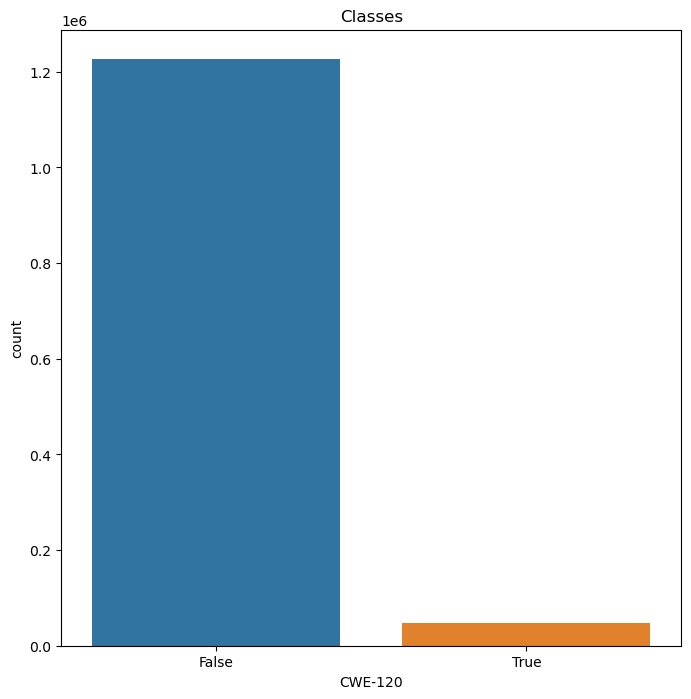

In [42]:
plot_classes(CWE_120_df, 'CWE-120')

We will have to fix this imbalance in the 5 previous datasets we created. This is important, because an imbalanced dataset will hinder the machine learning models and won't allow us to achieve decent classification results.  

To fix this we will apply under-sampling to generate a 50/50 non-vulnerable:vulnerable subset for each vulnerability dataset.

In [43]:
def undersample(dataset, vulnerability_class):
    shuffled_df = dataset.sample(frac=1, random_state=4)
    vul_df = shuffled_df.loc[shuffled_df[vulnerability_class] == True]
    non_vul_df = shuffled_df.loc[shuffled_df[vulnerability_class] == 0].sample(n=len(vul_df), random_state=42)
    normalized_df = pd.concat([vul_df, non_vul_df])
    return normalized_df

In [44]:
normalized_CWE_120 = undersample(CWE_120_df, 'CWE-120')
normalized_CWE_119 = undersample(CWE_119_df, 'CWE-119')
normalized_CWE_469 = undersample(CWE_469_df, 'CWE-469')
normalized_CWE_476 = undersample(CWE_476_df, 'CWE-476')
normalized_CWE_OTHERS = undersample(CWE_OTHERS_df, 'CWE-OTHERS')

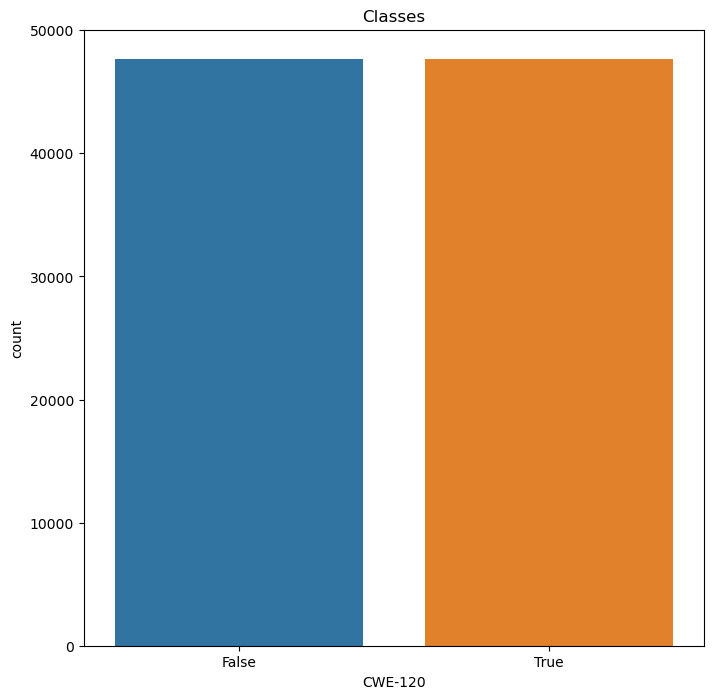

In [45]:
plot_classes(normalized_CWE_120, 'CWE-120')

Now we will prepare the dataset to be processed by clang and to generate the abstract syntax tree

In [46]:
def add_column(row):
    return {"filename": str(row.testCase_ID) + "_vdisc.c"}

def prepare_for_clang(dataset, vulnerability):
    dataset.reset_index(inplace=True)
    dataset['type'] = vulnerability
    dataset.columns = ['testCase_ID', 'code', 'vulnerable', 'type']
    dataset['testCase_ID'] = dataset.index
    filenames = dataset.apply(add_column, axis=1, result_type="expand")
    dataset.insert(1, "filename", filenames, True)

In [47]:
prepare_for_clang(normalized_CWE_119, 'CWE-119')
prepare_for_clang(normalized_CWE_120, 'CWE-120')
prepare_for_clang(normalized_CWE_469, 'CWE-469')
prepare_for_clang(normalized_CWE_476, 'CWE-476')
prepare_for_clang(normalized_CWE_OTHERS, 'CWE-OTHERS')

In [48]:
normalized_CWE_119

,testCase_ID,filename,code,vulnerable,type
0,0,0_vdisc.c,CDE_create_path_symlink_dirs() {\n char *p;\n...,True,CWE-119
1,1,1_vdisc.c,"gperror(unsigned int code,\n\t char *messa...",True,CWE-119
2,2,2_vdisc.c,test_date_rfc2822__format_rfc2822_positive_off...,True,CWE-119
3,3,3_vdisc.c,"toggle_cb (GtkWidget *item, char *pref_name)\n...",True,CWE-119
4,4,4_vdisc.c,"fixgrid34(NCDAPCOMMON* nccomm, CDFnode* grid)\...",True,CWE-119
...,...,...,...,...,...
48309,48309,48309_vdisc.c,fuse_graph_sync (xlator_t *this)\n{\n f...,False,CWE-119
48310,48310,48310_vdisc.c,"screen_resize(void)\n{\n gint w, h;\n GL...",False,CWE-119
48311,48311,48311_vdisc.c,"cmd_cmpfiles (const char *assign_to, char *arg...",False,CWE-119
48312,48312,48312_vdisc.c,etherType(PPPoEPacket *packet)\n{\n UINT16_...,False,CWE-119


We will save the processed datasets as CSVs to facilitate testing and developtment of this project.  

In [49]:
normalized_CWE_119.to_csv("./dataset/preprocessed/vdisc_CWE_119.csv.gz")
normalized_CWE_120.to_csv("./dataset/preprocessed/vdisc_CWE_120.csv.gz")
normalized_CWE_469.to_csv("./dataset/preprocessed/vdisc_CWE_469.csv.gz")
normalized_CWE_476.to_csv("./dataset/preprocessed/vdisc_CWE_476.csv.gz")
normalized_CWE_OTHERS.to_csv("./dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz")

## Extratcing the Abstract Syntax Tree

We will a set of functions to extract the AST of the code for each entry in our dataset. The functions we are using we're originally made by the author of the article which we're using as reference for this project, and use the python biddings for the clang compiler to enable the extraction of the AST.

In [2]:
from ast_extraction_graph2vec import *

Now we convert the CSVs to an AST. This takes some time to run! The AST for each function is saved on a graph2vec/vulnerability directory, and these will serve as input for graph2vec.

In [ ]:
graph_Representaion_process("./dataset/preprocessed/vdisc_CWE_119.csv.gz", "./dataset/graph2vec/CWE_119/", num_partitions=20)
graph_Representaion_process("./dataset/preprocessed/vdisc_CWE_120.csv.gz", "./dataset/graph2vec/CWE_120/", num_partitions=20)
graph_Representaion_process("./dataset/preprocessed/vdisc_CWE_469.csv.gz", "./dataset/graph2vec/CWE_469/", num_partitions=20)
graph_Representaion_process("./dataset/preprocessed/vdisc_CWE_476.csv.gz", "./dataset/graph2vec/CWE_476/", num_partitions=20)
graph_Representaion_process("./dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz", "./dataset/graph2vec/CWE_OTHERS/", num_partitions=20)

## Creating the Vector Embeddings with Graph2vec

To create the vector embedding of the graph structure (Abstract Syntax Tree) we use the following graph2vec library https://github.com/benedekrozemberczki/graph2vec  

The resulting vector embeddings will be saved in the following directory dataset/embeddings/  

In [ ]:
!python ./graph2vec-lib/src/graph2vec.py --input-path ./dataset/graph2vec/CWE_119/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_119.csv
!python ./graph2vec-lib/src/graph2vec.py --input-path ./dataset/graph2vec/CWE_120/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_120.csv
!python ./graph2vec-lib/src/graph2vec.py --input-path ./dataset/graph2vec/CWE_469/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_469.csv
!python ./graph2vec-lib/src/graph2vec.py --input-path ./dataset/graph2vec/CWE_476/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_476.csv
!python ./graph2vec-lib/src/graph2vec.py --input-path ./dataset/graph2vec/CWE_OTHERS/graph2vec_input/ --output ./dataset/embeddings/vector_CWE_OTHERS.csv

With this new representation of our dataset we can now train regular ML models.

## Creating a dataset on Pytorch Geometric to train the Graph Neural Network

The Graph Neural Network model we will be using, uses the graphs directly for training and for predictions. So inn order to train the Graph Neural Network we will have to extract the ASTs from each C/C++ function and build a dataset on Pytorch Geometric with these graphs.  

We will use the following Dataset class that the author of the original article created.  

In [1]:
from ast_extraction_pytorch import *

class GraphDataset(Dataset):
    def __init__(self, root, path_dataset, transform=None, pre_transform=None):
        self.path_to_data = path_dataset
        super(GraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    # Dataset class requires the implementation of this method
    @property
    def processed_file_names(self):
        return 'not_implemented.pt'
    
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.path_to_data)
        for index, vuln in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            data = clang_process_pytorch(vuln)
            torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))
        return data

Now we can create a GraphDataset based on the previously preprocessed datasets. This will also create a folder with all the graphs, one in each file, for the specified root directory.

In [2]:
graph_CWE_119 = GraphDataset(root='./dataset/preprocessed/CWE_119', path_dataset='./dataset/preprocessed/vdisc_CWE_119.csv.gz')
graph_CWE_120 = GraphDataset(root='./dataset/preprocessed/CWE_120', path_dataset='./dataset/preprocessed/vdisc_CWE_120.csv.gz')
graph_CWE_469 = GraphDataset(root='./dataset/preprocessed/CWE_469', path_dataset='./dataset/preprocessed/vdisc_CWE_469.csv.gz')
graph_CWE_476 = GraphDataset(root='./dataset/preprocessed/CWE_470', path_dataset='./dataset/preprocessed/vdisc_CWE_476.csv.gz')
graph_CWE_OTHERS = GraphDataset(root='./dataset/preprocessed/CWE_OTHERS', path_dataset='./dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz')

Processing...
100%|██████████| 48314/48314 [11:27<00:00, 70.23it/s]
Done!
Processing...
100%|██████████| 95320/95320 [22:53<00:00, 69.38it/s]
Done!
Processing...
100%|██████████| 5250/5250 [01:24<00:00, 61.99it/s]
Done!
Processing...
100%|██████████| 24188/24188 [06:03<00:00, 66.59it/s]
Done!
Processing...
100%|██████████| 70056/70056 [19:00<00:00, 61.41it/s]
Done!


## Training and Validation of Models

Now that we have obtained preprocessed datasets in both embedding and graph format we can create our models and begin training and validating them.

### Graph Neural Network

First let's explore the graph dataset a little bit

In [ ]:
print(f"Number of graphs in dataset: {len(graph_CWE_119)}")
print(f"First Graph Object of the dataset: {graph_CWE_119[0]}")
print(f'Number of nodes: {graph_CWE_119[0].num_nodes}')
print(f'Number of edges: {graph_CWE_119[0].num_edges}')

Number of graphs in dataset: 48314
First Graph Object of the dataset: Data(x=[153, 2], edge_index=[2, 152], y=[1])
Number of nodes: 153
Number of edges: 152


In [ ]:
print(graph_CWE_119[2].edge_index.t())

tensor([[0, 1],
        [1, 2],
        [1, 3],
        [1, 4],
        [4, 5],
        [5, 6],
        [4, 7],
        [7, 8],
        [8, 9]])


In [ ]:
print(graph_CWE_119[2].x)

tensor([[ 1.,  1.],
        [ 2.,  1.],
        [ 3.,  2.],
        [ 4.,  1.],
        [ 5.,  0.],
        [ 6.,  2.],
        [ 7.,  0.],
        [ 8.,  2.],
        [ 9.,  3.],
        [10.,  0.],
        [11.,  0.],
        [12.,  0.],
        [13.,  0.]])


#### Splitting the dataset

Now we will split the dataset into train (80%), test (10%) and validation (10%)

In [ ]:
#CWE-119
graph_CWE_119 = graph_CWE_119.shuffle()
ten_percent_length = int(len(graph_CWE_119) * 0.1)
train_graphCWE119 = graph_CWE_119[:ten_percent_length * 8]
val_graphCWE119 = graph_CWE_119[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWE119 = graph_CWE_119[ten_percent_length * 9:]

#CWE-120
graph_CWE_120 = graph_CWE_120.shuffle()
ten_percent_length = int(len(graph_CWE_120) * 0.1)
train_graphCWE120 = graph_CWE_120[:ten_percent_length * 8]
val_graphCWE120 = graph_CWE_120[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWE120 = graph_CWE_120[ten_percent_length * 9:]

#CWE-469
graph_CWE_469 = graph_CWE_469.shuffle()
ten_percent_length = int(len(graph_CWE_469) * 0.1)
train_graphCWE469 = graph_CWE_469[:ten_percent_length * 8]
val_graphCWE469 = graph_CWE_469[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWE469 = graph_CWE_469[ten_percent_length * 9:]

#CWE-476
graph_CWE_476 = graph_CWE_476.shuffle()
ten_percent_length = int(len(graph_CWE_476) * 0.1)
train_graphCWE476 = graph_CWE_476[:ten_percent_length * 8]
val_graphCWE476 = graph_CWE_476[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWE476 = graph_CWE_476[ten_percent_length * 9:]

#CWE_OTHERS
graph_CWE_OTHERS = graph_CWE_OTHERS.shuffle()
ten_percent_length = int(len(graph_CWE_OTHERS) * 0.1)
train_graphCWEOTHERS = graph_CWE_OTHERS[:ten_percent_length * 8]
val_graphCWEOTHERS = graph_CWE_OTHERS[ten_percent_length * 8: ten_percent_length * 9]
test_graphCWEOTHERS = graph_CWE_OTHERS[ten_percent_length * 9:]

Create dataloaders for PyTorch to iterate over the datasets

In [ ]:
from torch_geometric.data import DataLoader
NUM_GRAPHS_PER_BATCH = 256

# CWE-119 DataLoaders
train_loader_CWE119 = DataLoader(train_graphCWE119, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWE119 = DataLoader(val_graphCWE119, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWE119 = DataLoader(test_graphCWE119, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)

# CWE-120 DataLoaders
train_loader_CWE120 = DataLoader(train_graphCWE120, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWE120 = DataLoader(val_graphCWE120, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWE120 = DataLoader(test_graphCWE120, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)

# CWE-469 DataLoaders
train_loader_CWE469 = DataLoader(train_graphCWE469, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWE469 = DataLoader(val_graphCWE469, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWE469 = DataLoader(test_graphCWE469, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)

# CWE-476 DataLoaders
train_loader_CWE476 = DataLoader(train_graphCWE476, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWE476 = DataLoader(val_graphCWE476, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWE476 = DataLoader(test_graphCWE476, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)

# CWE-OTHERS DataLoaders
train_loader_CWEOTHERS = DataLoader(train_graphCWEOTHERS, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
val_loader_CWEOTHERS = DataLoader(val_graphCWEOTHERS, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)
test_loader_CWEOTHERS = DataLoader(test_graphCWEOTHERS, batch_size=NUM_GRAPHS_PER_BATCH, drop_last=True, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#### Creating the GNN Model

The GNN will be built using PyToch and it follows this architecture:
-     Initial GCNConv layer: Translates input node features into embeddings with a specified embedding size (128 neurons) and applies a ReLU activation function.
-    Two subsequent GCNConv layers: Each with 128 neurons and ReLU activation functions.
-    Global Pooling: Combines global max pooling and global mean pooling to aggregate node features into a single feature representation for each graph.
-    Fully connected (Linear) layers:
     -   First Linear layer: 128 neurons with a ReLU activation function
     -   Second Linear layer: 128 neurons with a ReLU activation function
-    Output Layer: 1 neuron with a Sigmoid activation function

In [ ]:
import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

embedding_size = 128

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        # Initial GCNConv layer: translates our node features into the size of the embedding
        self.initial_conv = GCNConv(2, embedding_size)
        # Two more GCNConv layers to process graph information
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)

        # Output layers
        # Linear layers for classification
        self.lin1 = Linear(embedding_size * 2, 128)
        self.lin2 = Linear(128, 128)
        self.lin3 = Linear(128, 1)

        # Activation functions
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        # Second Conv layer
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)

        # Third Conv layer
        hidden = self.conv2(hidden, edge_index)

        # Global Pooling (stack different aggregations)
        # Concatenate the global max pool and global mean pool results
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply the final linear classifier layers
        out = self.lin1(hidden)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        out = self.lin3(out)
        out = torch.sigmoid(out)

        return out

Now we will define somes functions to train the GNN, we will be using an early stopping mechanism that stops the training if the validation loss doesn't improve after the specified period (5 epochs by default)

In [ ]:
def train(model, optimizer, loss_fn, train_loader, device):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.float(), data.edge_index, data.batch)
        label = data.y.to(device)
        loss = loss_fn(output.squeeze(), label.float())  
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def evaluate(model, loader, loss_fn, device):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data.x.float(), data.edge_index, data.batch)
            label_true = data.y.to(device)
            label = data.y.detach().cpu().numpy()
            predictions.append(np.rint(pred.cpu().detach().numpy()))
            labels.append(label)
            loss = loss_fn(pred.squeeze(), label_true.float())

    predictions = np.concatenate(predictions).ravel()
    labels = np.concatenate(labels).ravel()

    return accuracy_score(labels, predictions), loss

def train_evaluate_GNN(train_loader, val_loader, device, model, optimizer, loss_fn, epochs=200, early_stopping_patience=5):
    print("Starting training...")
    train_losses = []
    val_losses = []
    val_acc_list= []
    train_acc_list= []
    best_loss = 1000
    early_stopping_counter = 0
    for epoch in range(epochs):
        if early_stopping_counter <= early_stopping_patience:
            loss = train(model, optimizer, loss_fn, train_loader, device)
            train_losses.append(loss)
            train_acc, train_loss = evaluate(model, train_loader, loss_fn, device)
            val_acc, val_loss = evaluate(model, val_loader, loss_fn, device)
            val_losses.append(val_loss)
            val_acc_list.append(val_acc)
            train_acc_list.append(train_acc)
        
            if float(val_loss) < best_loss:
                best_loss = val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            print(f"Epoch {epoch} | Train Loss {loss} | Train Accuracy {train_acc} | Validation Accuracy {val_acc} | Validation loss {val_loss}")

        else:
            print("Early stopping due to no improvement.")
            break
    print(f"Finishing training with best val loss: {best_loss}")

    return train_losses, val_losses, train_acc_list, val_acc_list



#### Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.BCELoss()

- CWE-119

In [ ]:
model_CWE119 = GCN().to(device)
optimizer_CWE119 = torch.optim.Adam(model_CWE119.parameters(), lr=0.01)

train_losses_CWE119, val_losses_CWE119, train_acc_list_CWE119, val_acc_list_CWE119 = train_evaluate_GNN(
    train_loader=train_loader_CWE119,
    val_loader=val_loader_CWE119,
    device=device,
    model=model_CWE119,
    optimizer=optimizer_CWE119,
    loss_fn=loss_fn
)

Starting training...
Epoch 0 | Train Loss 0.6181547460633019 | Train Accuracy 0.6858333333333333 | Validation Accuracy 0.6875 | Validation loss 0.6006382703781128


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.5813036492043118 | Train Accuracy 0.6980989583333334 | Validation Accuracy 0.697265625 | Validation loss 0.5740605592727661


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.5766947925325211 | Train Accuracy 0.7075260416666667 | Validation Accuracy 0.7085503472222222 | Validation loss 0.6030550003051758


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.572250980739637 | Train Accuracy 0.7154947916666666 | Validation Accuracy 0.7200520833333334 | Validation loss 0.5378669500350952


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.5612767603895329 | Train Accuracy 0.7180208333333333 | Validation Accuracy 0.7194010416666666 | Validation loss 0.5341914892196655


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.5500072127073553 | Train Accuracy 0.7187239583333334 | Validation Accuracy 0.7217881944444444 | Validation loss 0.5445019006729126


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.5452120322367835 | Train Accuracy 0.72234375 | Validation Accuracy 0.7224392361111112 | Validation loss 0.5727318525314331


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.5389878435476402 | Train Accuracy 0.7334114583333333 | Validation Accuracy 0.7322048611111112 | Validation loss 0.5185093879699707


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.5314275042360749 | Train Accuracy 0.711796875 | Validation Accuracy 0.7178819444444444 | Validation loss 0.5705916881561279


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.5307017474212994 | Train Accuracy 0.7357291666666667 | Validation Accuracy 0.734375 | Validation loss 0.5509141087532043


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 10 | Train Loss 0.5244351904033455 | Train Accuracy 0.7428645833333334 | Validation Accuracy 0.74609375 | Validation loss 0.5161957740783691


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 11 | Train Loss 0.5243172956485231 | Train Accuracy 0.7426822916666667 | Validation Accuracy 0.7467447916666666 | Validation loss 0.5393288135528564


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 12 | Train Loss 0.5207021257640955 | Train Accuracy 0.7352604166666666 | Validation Accuracy 0.7252604166666666 | Validation loss 0.4770262837409973


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 13 | Train Loss 0.5224020047307236 | Train Accuracy 0.7514583333333333 | Validation Accuracy 0.7450086805555556 | Validation loss 0.4763702154159546


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 14 | Train Loss 0.5210333904897271 | Train Accuracy 0.7438541666666667 | Validation Accuracy 0.7400173611111112 | Validation loss 0.500049352645874


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 15 | Train Loss 0.5181885811883307 | Train Accuracy 0.744609375 | Validation Accuracy 0.7545572916666666 | Validation loss 0.5356825590133667


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 16 | Train Loss 0.5182012241342205 | Train Accuracy 0.7471354166666667 | Validation Accuracy 0.7371961805555556 | Validation loss 0.4854007661342621


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 17 | Train Loss 0.5147694530656831 | Train Accuracy 0.7562239583333333 | Validation Accuracy 0.7495659722222222 | Validation loss 0.47664040327072144


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 18 | Train Loss 0.510650938377941 | Train Accuracy 0.7559635416666667 | Validation Accuracy 0.7571614583333334 | Validation loss 0.4873942732810974


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 19 | Train Loss 0.512167382995378 | Train Accuracy 0.744375 | Validation Accuracy 0.7389322916666666 | Validation loss 0.48505163192749023
Early stopping due to no improvement.
Finishing training with best val loss: 0.4763702154159546


- CWE-120

In [ ]:
model_CWE120 = GCN().to(device)
optimizer_CWE120 = torch.optim.Adam(model_CWE120.parameters(), lr=0.01)

train_losses_CWE120, val_losses_CWE120, train_acc_list_CWE120, val_acc_list_CWE120 = train_evaluate_GNN(
    train_loader=train_loader_CWE120,
    val_loader=val_loader_CWE120,
    device=device,
    model=model_CWE120,
    optimizer=optimizer_CWE120,
    loss_fn=loss_fn
)

Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.6207952275278185 | Train Accuracy 0.6750973274410774 | Validation Accuracy 0.6774704391891891 | Validation loss 0.5920318365097046


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.6063394882675984 | Train Accuracy 0.6790824915824916 | Validation Accuracy 0.6805320945945946 | Validation loss 0.6034666299819946


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.6050765833532515 | Train Accuracy 0.6758864688552189 | Validation Accuracy 0.6768369932432432 | Validation loss 0.561429500579834


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.6045991464967844 | Train Accuracy 0.6746238425925926 | Validation Accuracy 0.6764146959459459 | Validation loss 0.6572636365890503


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.6023334754498826 | Train Accuracy 0.6777014941077442 | Validation Accuracy 0.6744087837837838 | Validation loss 0.6229983568191528


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.5994557854111736 | Train Accuracy 0.6757286405723906 | Validation Accuracy 0.6795819256756757 | Validation loss 0.6013748645782471


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.6001202420832177 | Train Accuracy 0.6792929292929293 | Validation Accuracy 0.6768369932432432 | Validation loss 0.6113134622573853


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.5986823053155884 | Train Accuracy 0.6835411405723906 | Validation Accuracy 0.6847550675675675 | Validation loss 0.5832114219665527


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.5960694209797963 | Train Accuracy 0.6825941708754208 | Validation Accuracy 0.686549831081081 | Validation loss 0.5954886078834534
Early stopping due to no improvement.
Finishing training with best val loss: 0.561429500579834


- CWE-469

In [ ]:
model_CWE469 = GCN().to(device)
optimizer_CWE469 = torch.optim.Adam(model_CWE469.parameters(), lr=0.01)

train_losses_CWE469, val_losses_CWE469, train_acc_list_CWE469, val_acc_list_CWE469 = train_evaluate_GNN(
    train_loader=train_loader_CWE469,
    val_loader=val_loader_CWE469,
    device=device,
    model=model_CWE469,
    optimizer=optimizer_CWE469,
    loss_fn=loss_fn
)


Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.831660381498791 | Train Accuracy 0.697998046875 | Validation Accuracy 0.6953125 | Validation loss 0.601212739944458


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.5709385463169643 | Train Accuracy 0.706787109375 | Validation Accuracy 0.69921875 | Validation loss 0.6072912216186523


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.5691839018322172 | Train Accuracy 0.708984375 | Validation Accuracy 0.701171875 | Validation loss 0.5849836468696594


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.5791456749325706 | Train Accuracy 0.70947265625 | Validation Accuracy 0.705078125 | Validation loss 0.5986648797988892


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.5651116761707125 | Train Accuracy 0.703369140625 | Validation Accuracy 0.697265625 | Validation loss 0.5753083825111389


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.5610042099725633 | Train Accuracy 0.70458984375 | Validation Accuracy 0.697265625 | Validation loss 0.6098107695579529


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.5621892547607422 | Train Accuracy 0.703857421875 | Validation Accuracy 0.69921875 | Validation loss 0.5913417339324951


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.5654744211832682 | Train Accuracy 0.7099609375 | Validation Accuracy 0.708984375 | Validation loss 0.5767530202865601


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.5599609756469727 | Train Accuracy 0.712646484375 | Validation Accuracy 0.701171875 | Validation loss 0.5603116750717163


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.5615421440487817 | Train Accuracy 0.700927734375 | Validation Accuracy 0.6875 | Validation loss 0.5834145545959473


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 10 | Train Loss 0.5621709950764974 | Train Accuracy 0.713134765625 | Validation Accuracy 0.70703125 | Validation loss 0.6093152761459351


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 11 | Train Loss 0.5598773375011625 | Train Accuracy 0.708984375 | Validation Accuracy 0.69140625 | Validation loss 0.5764850974082947


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 12 | Train Loss 0.5628754134405227 | Train Accuracy 0.707275390625 | Validation Accuracy 0.6953125 | Validation loss 0.5926002264022827


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 13 | Train Loss 0.5601892416817801 | Train Accuracy 0.7041015625 | Validation Accuracy 0.69921875 | Validation loss 0.608988881111145


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 14 | Train Loss 0.5627628471737817 | Train Accuracy 0.703125 | Validation Accuracy 0.6953125 | Validation loss 0.57017982006073
Early stopping due to no improvement.
Finishing training with best val loss: 0.5603116750717163


- CWE-476

In [ ]:
model_CWE476 = GCN().to(device)
optimizer_CWE476 = torch.optim.Adam(model_CWE476.parameters(), lr=0.01)

train_losses_CWE476, val_losses_CWE476, train_acc_list_CWE476, val_acc_list_CWE476 = train_evaluate_GNN(
    train_loader=train_loader_CWE476,
    val_loader=val_loader_CWE476,
    device=device,
    model=model_CWE476,
    optimizer=optimizer_CWE476,
    loss_fn=loss_fn
)

Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.7216086880642092 | Train Accuracy 0.5369270833333334 | Validation Accuracy 0.5134548611111112 | Validation loss 0.6923743486404419


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.679299449210723 | Train Accuracy 0.56359375 | Validation Accuracy 0.57421875 | Validation loss 0.6736933588981628


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.6785410698826793 | Train Accuracy 0.5611458333333333 | Validation Accuracy 0.5750868055555556 | Validation loss 0.6762155890464783


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.6770610130947419 | Train Accuracy 0.5624479166666667 | Validation Accuracy 0.5733506944444444 | Validation loss 0.6683133840560913


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.6769968629179166 | Train Accuracy 0.5641145833333333 | Validation Accuracy 0.5768229166666666 | Validation loss 0.6620839834213257


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.6768521465872613 | Train Accuracy 0.5503645833333334 | Validation Accuracy 0.5698784722222222 | Validation loss 0.6773914098739624


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.6763976919838375 | Train Accuracy 0.5586979166666667 | Validation Accuracy 0.5785590277777778 | Validation loss 0.6810940504074097


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.6749420481540627 | Train Accuracy 0.5658333333333333 | Validation Accuracy 0.5559895833333334 | Validation loss 0.6913920044898987


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.6752369267768955 | Train Accuracy 0.56765625 | Validation Accuracy 0.5755208333333334 | Validation loss 0.6902777552604675


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.6737984222651908 | Train Accuracy 0.5733333333333334 | Validation Accuracy 0.57421875 | Validation loss 0.6686475276947021


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 10 | Train Loss 0.6733073754385545 | Train Accuracy 0.5683854166666666 | Validation Accuracy 0.5785590277777778 | Validation loss 0.6633231043815613
Early stopping due to no improvement.
Finishing training with best val loss: 0.6620839834213257


- CWE Others

In [ ]:
model_CWEOTHERS = GCN().to(device)
optimizer_CWEOTHERS = torch.optim.Adam(model_CWEOTHERS.parameters(), lr=0.01)

train_losses_CWEOTHERS, val_losses_CWEOTHERS, train_acc_list_CWEOTHERS, val_acc_list_CWEOTHERS = train_evaluate_GNN(
    train_loader=train_loader_CWEOTHERS,
    val_loader=val_loader_CWEOTHERS,
    device=device,
    model=model_CWEOTHERS,
    optimizer=optimizer_CWEOTHERS,
    loss_fn=loss_fn)

Starting training...


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 0 | Train Loss 0.6568994801185711 | Train Accuracy 0.6187105791284404 | Validation Accuracy 0.6141493055555556 | Validation loss 0.635888934135437


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 1 | Train Loss 0.6491530054216297 | Train Accuracy 0.6268456135321101 | Validation Accuracy 0.6190682870370371 | Validation loss 0.6702065467834473


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 2 | Train Loss 0.646802870092181 | Train Accuracy 0.6272756594036697 | Validation Accuracy 0.6179108796296297 | Validation loss 0.6746686697006226


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 3 | Train Loss 0.6468989451896455 | Train Accuracy 0.6256988245412844 | Validation Accuracy 0.6195023148148148 | Validation loss 0.6126716732978821


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 4 | Train Loss 0.646289561596366 | Train Accuracy 0.6262005447247706 | Validation Accuracy 0.6182002314814815 | Validation loss 0.6397092342376709


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 5 | Train Loss 0.6454550534125144 | Train Accuracy 0.6292467029816514 | Validation Accuracy 0.6182002314814815 | Validation loss 0.6372199058532715


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 6 | Train Loss 0.6457215556240694 | Train Accuracy 0.6272756594036697 | Validation Accuracy 0.6193576388888888 | Validation loss 0.6494389772415161


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 7 | Train Loss 0.6451797183116448 | Train Accuracy 0.6293900516055045 | Validation Accuracy 0.6195023148148148 | Validation loss 0.6344503164291382


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 8 | Train Loss 0.644987559675915 | Train Accuracy 0.6277952981651376 | Validation Accuracy 0.6213831018518519 | Validation loss 0.6624324321746826


/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Epoch 9 | Train Loss 0.6442985875022829 | Train Accuracy 0.6177788130733946 | Validation Accuracy 0.6153067129629629 | Validation loss 0.644528329372406
Early stopping due to no improvement.
Finishing training with best val loss: 0.6126716732978821


#### Evaluation

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(train_losses, val_losses, train_acc_list, val_acc_list, cwe_name):
    with torch.no_grad():
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 13))
        
        ax1.plot(train_losses, label="train_loss")
        ax1.plot(val_losses, label="val_loss")
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.set_xlabel('Epochs', fontsize=14)
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='best', fontsize=14)
        ax1.set_title(f'{cwe_name} Loss', fontsize=14)

        ax2.plot(train_acc_list, label='train_acc')
        ax2.plot(val_acc_list, label='val_acc')
        ax2.legend(fontsize=14)
        ax2.set_ylabel('Accuracy', fontsize=14)
        ax2.set_xlabel('Epochs', fontsize=14)
        ax2.set_title(f'{cwe_name} Accuracy', fontsize=14)

        plt.savefig(f'CWE_{cwe_name}_gnn_losses.png')
        plt.show()


def print_metrics(loader, model):
    #model.eval()
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data.x.float(), data.edge_index, data.batch)
            pred_cpu = pred.cpu()
            label_true = data.y.to(device)
            label = data.y.detach().cpu().numpy()
            
            accuracy = accuracy_score(label, np.rint(pred_cpu))
            precision = precision_score(label, np.rint(pred_cpu), zero_division=1)
            recall = recall_score(label, np.rint(pred_cpu), zero_division=1)
            f1 = f1_score(label, np.rint(pred_cpu), zero_division=1)
            
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")
            print("\nConfusion Matrix:")
            print(confusion_matrix(label, np.rint(pred_cpu)))


- CWE-119

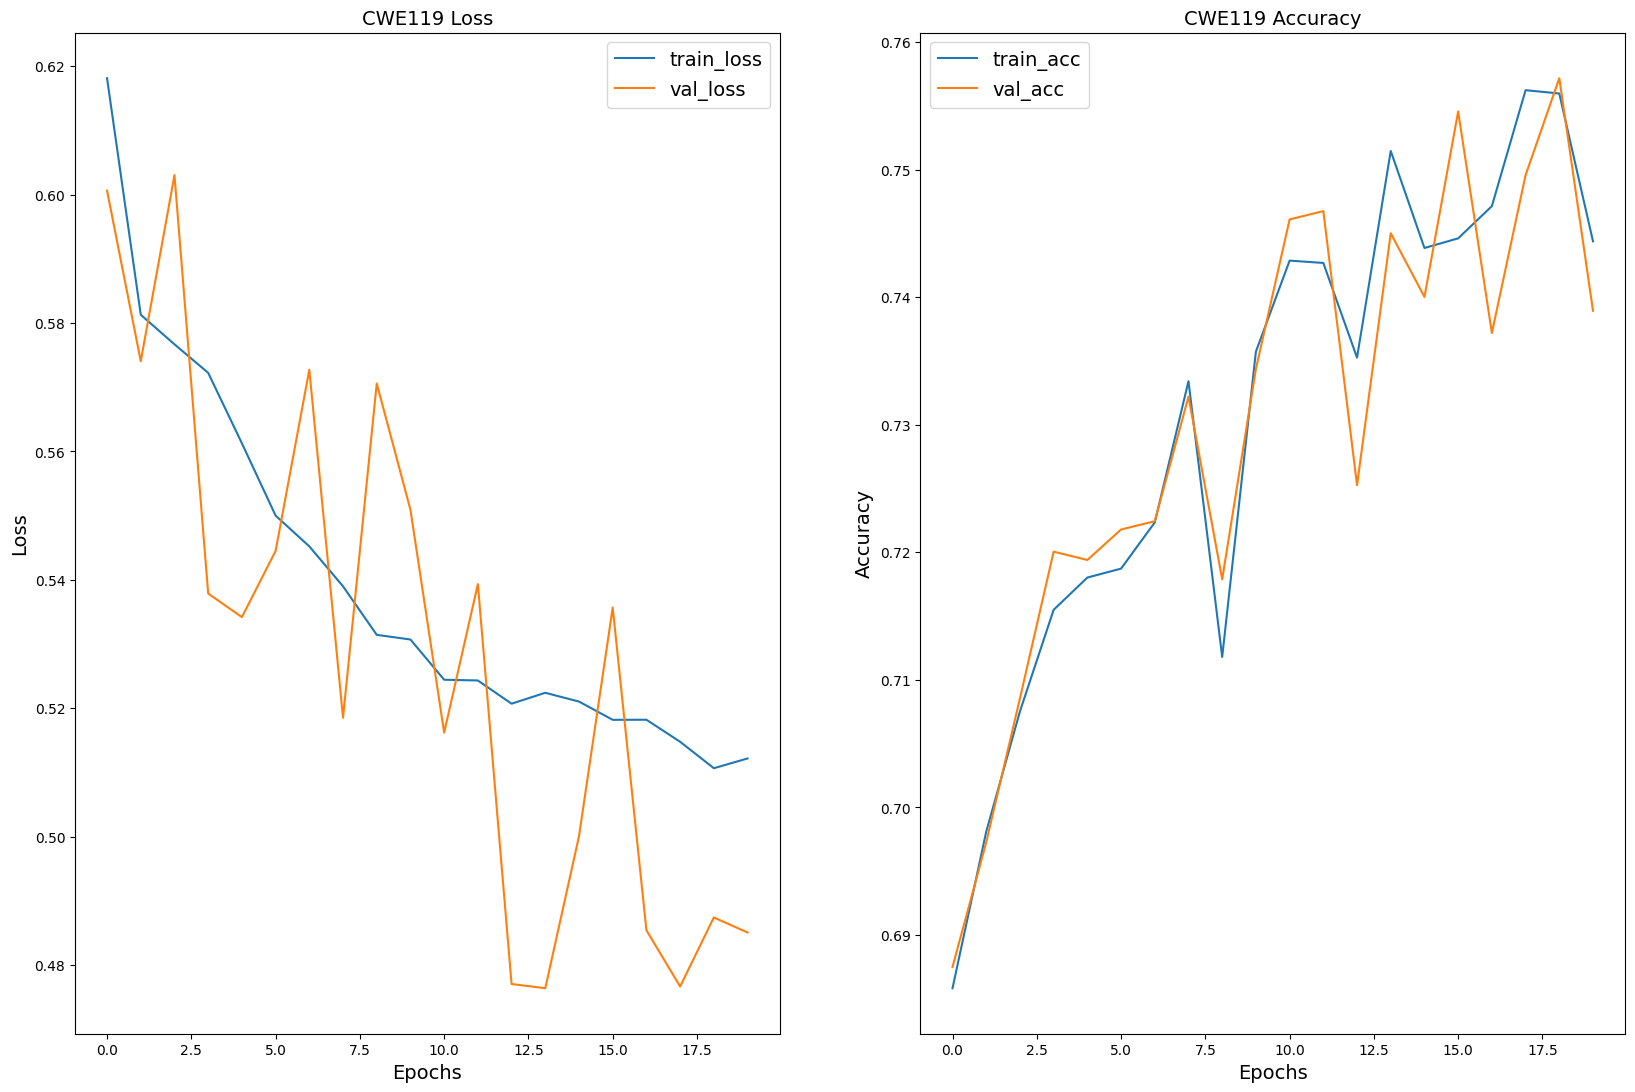

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.7466390899689762
Precision: 0.7767265846736046
Recall: 0.6855949895615866
F1 Score: 0.7283211355067643

Confusion Matrix:
[[1968  472]
 [ 753 1642]]


In [ ]:
val_losses_CWE119 = [x.item() for x in val_losses_CWE119] # Transfer values from gpu to cpu
plot_curves(train_losses_CWE119, val_losses_CWE119, train_acc_list_CWE119, val_acc_list_CWE119, "CWE119")
test_loader_all_119 = DataLoader(test_graphCWE119, batch_size=len(test_graphCWE119), drop_last=True, shuffle=True)
print_metrics(test_loader_all_119, model_CWE119)

- CWE-120

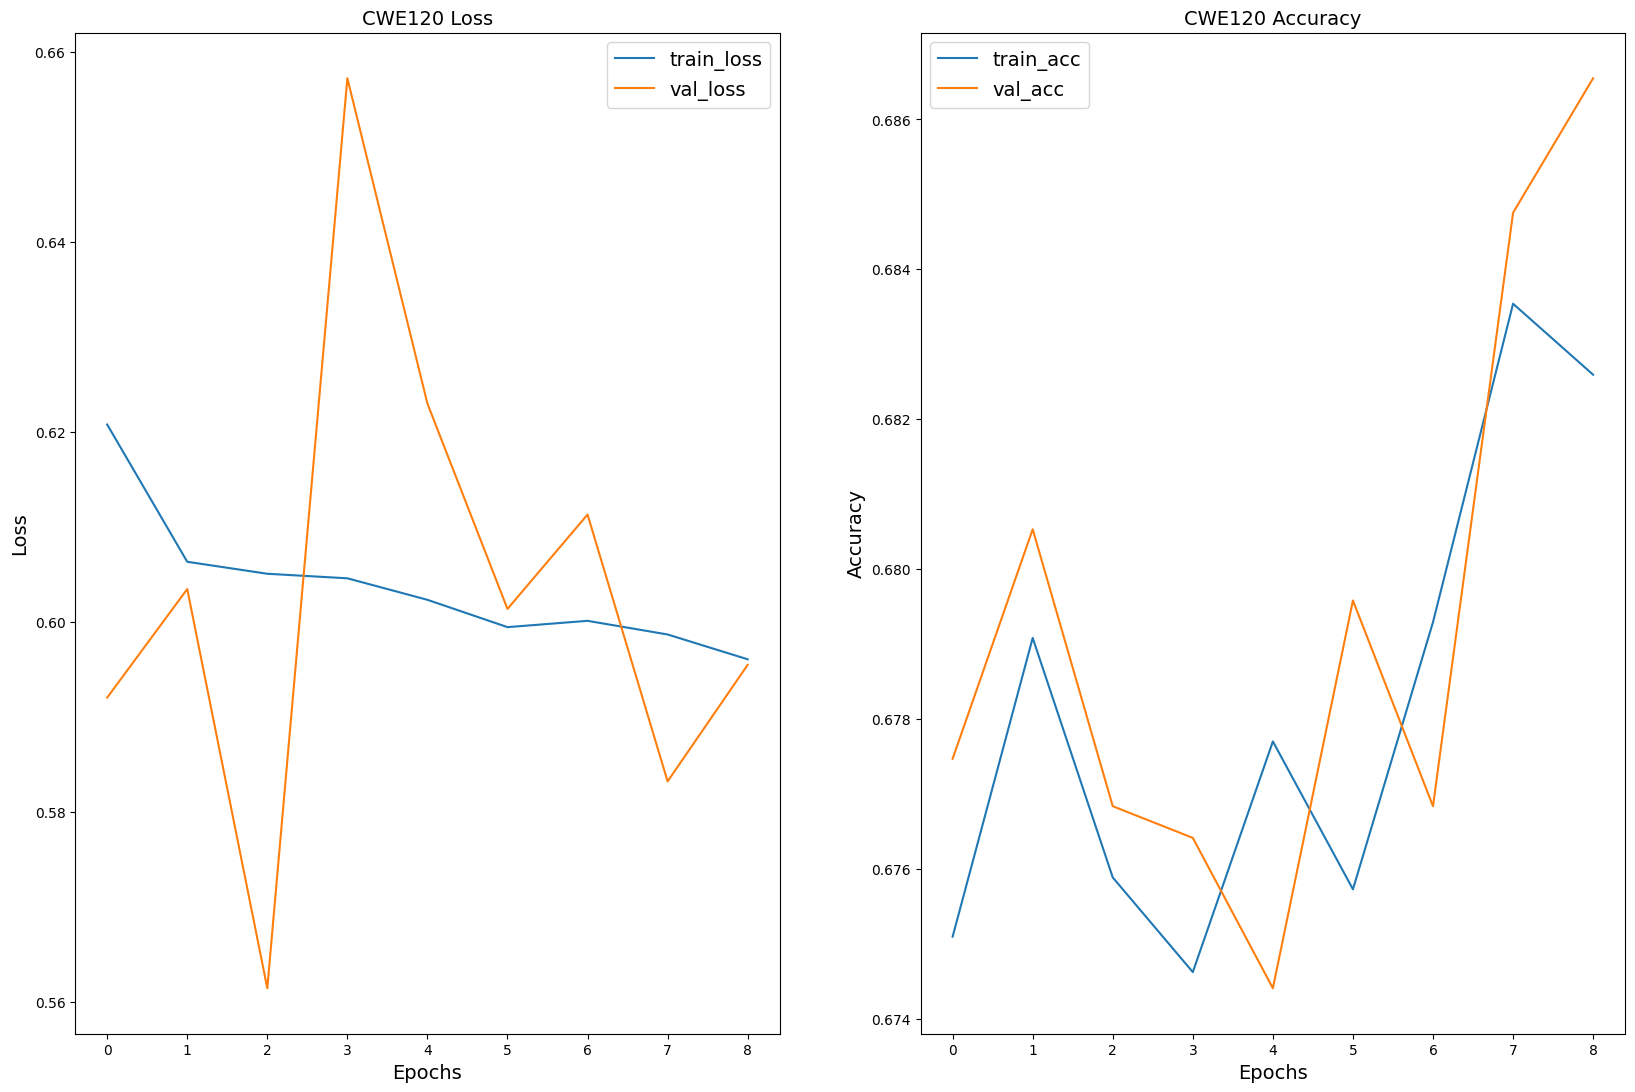

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.6807595467897608
Precision: 0.6832907075873828
Recall: 0.6731051858072643
F1 Score: 0.6781597038603913

Confusion Matrix:
[[3283 1486]
 [1557 3206]]


In [ ]:
val_losses_CWE120 = [x.item() for x in val_losses_CWE120] # Transfer values from gpu to cpu
plot_curves(train_losses_CWE120, val_losses_CWE120, train_acc_list_CWE120, val_acc_list_CWE120, "CWE120")
test_loader_all_120 = DataLoader(test_graphCWE120, batch_size=len(test_graphCWE120), drop_last=True, shuffle=True)
print_metrics(test_loader_all_120, model_CWE120)

- CWE-469

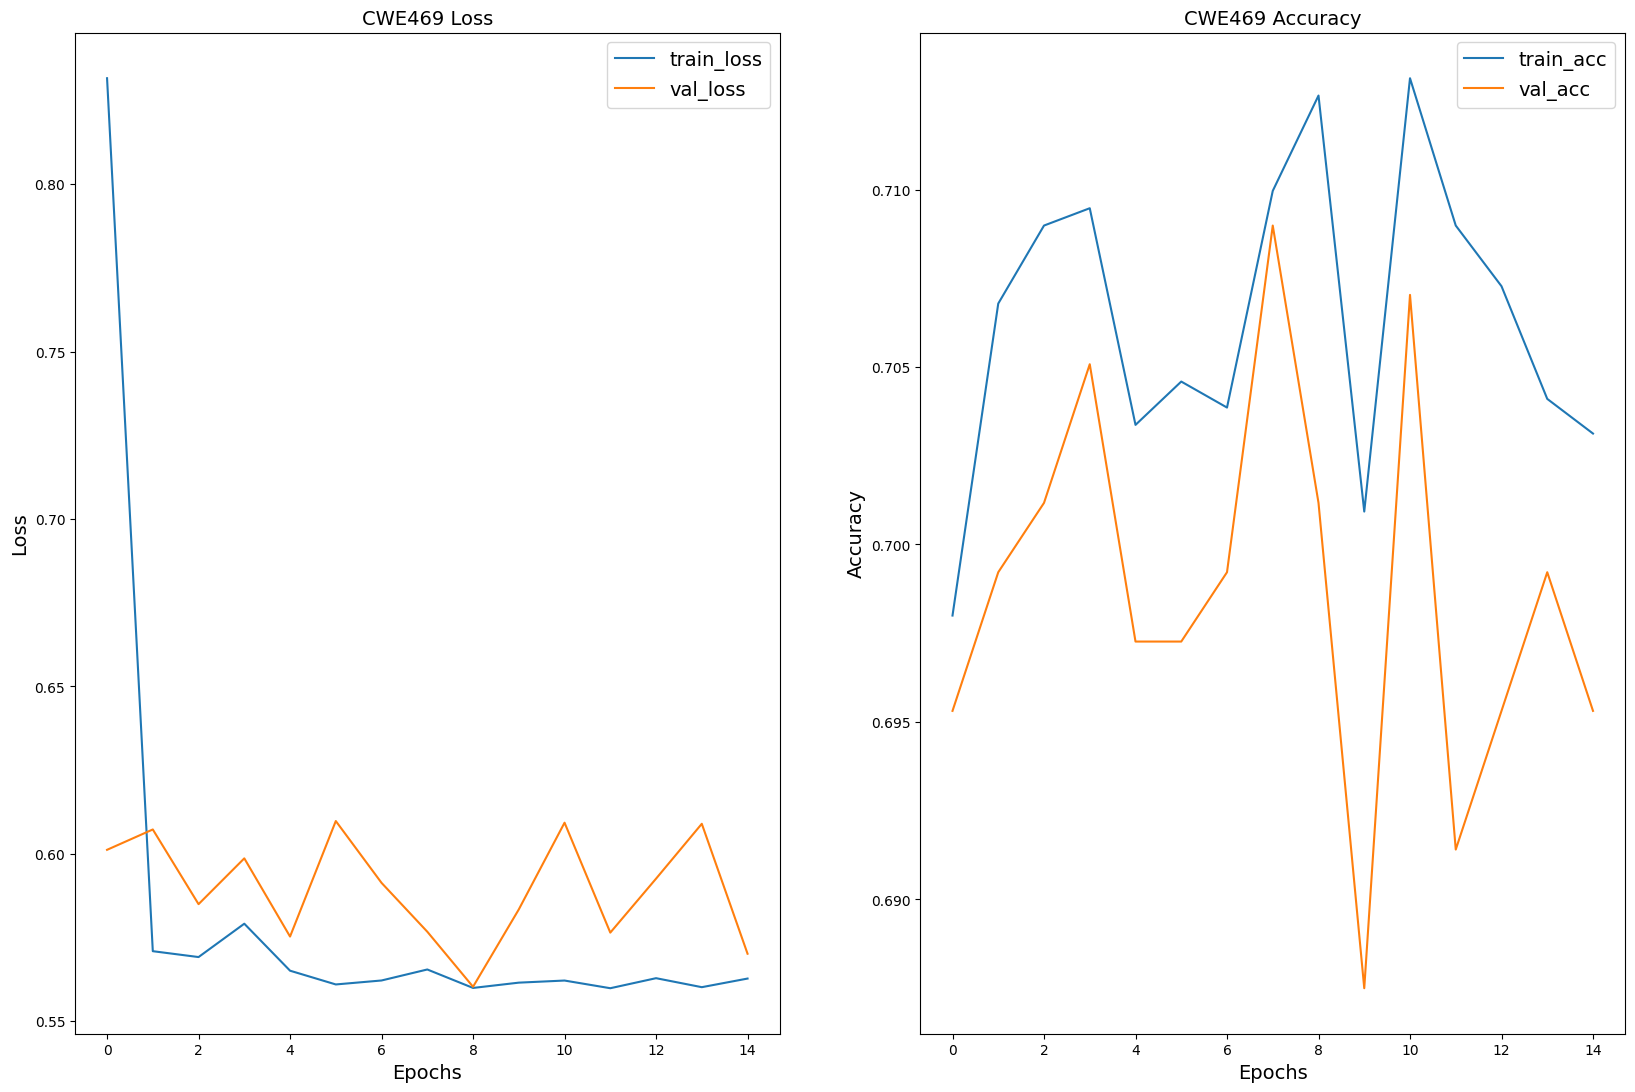

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.68
Precision: 0.703125
Recall: 0.6617647058823529
F1 Score: 0.6818181818181819

Confusion Matrix:
[[177  76]
 [ 92 180]]


In [ ]:
val_losses_CWE469 = [x.item() for x in val_losses_CWE469] # Transfer values from gpu to cpu
plot_curves(train_losses_CWE469, val_losses_CWE469, train_acc_list_CWE469, val_acc_list_CWE469, "CWE469")
test_loader_all_469 = DataLoader(test_graphCWE469, batch_size=len(test_graphCWE469), drop_last=True, shuffle=True)
print_metrics(test_loader_all_469, model_CWE469)

- CWE-476

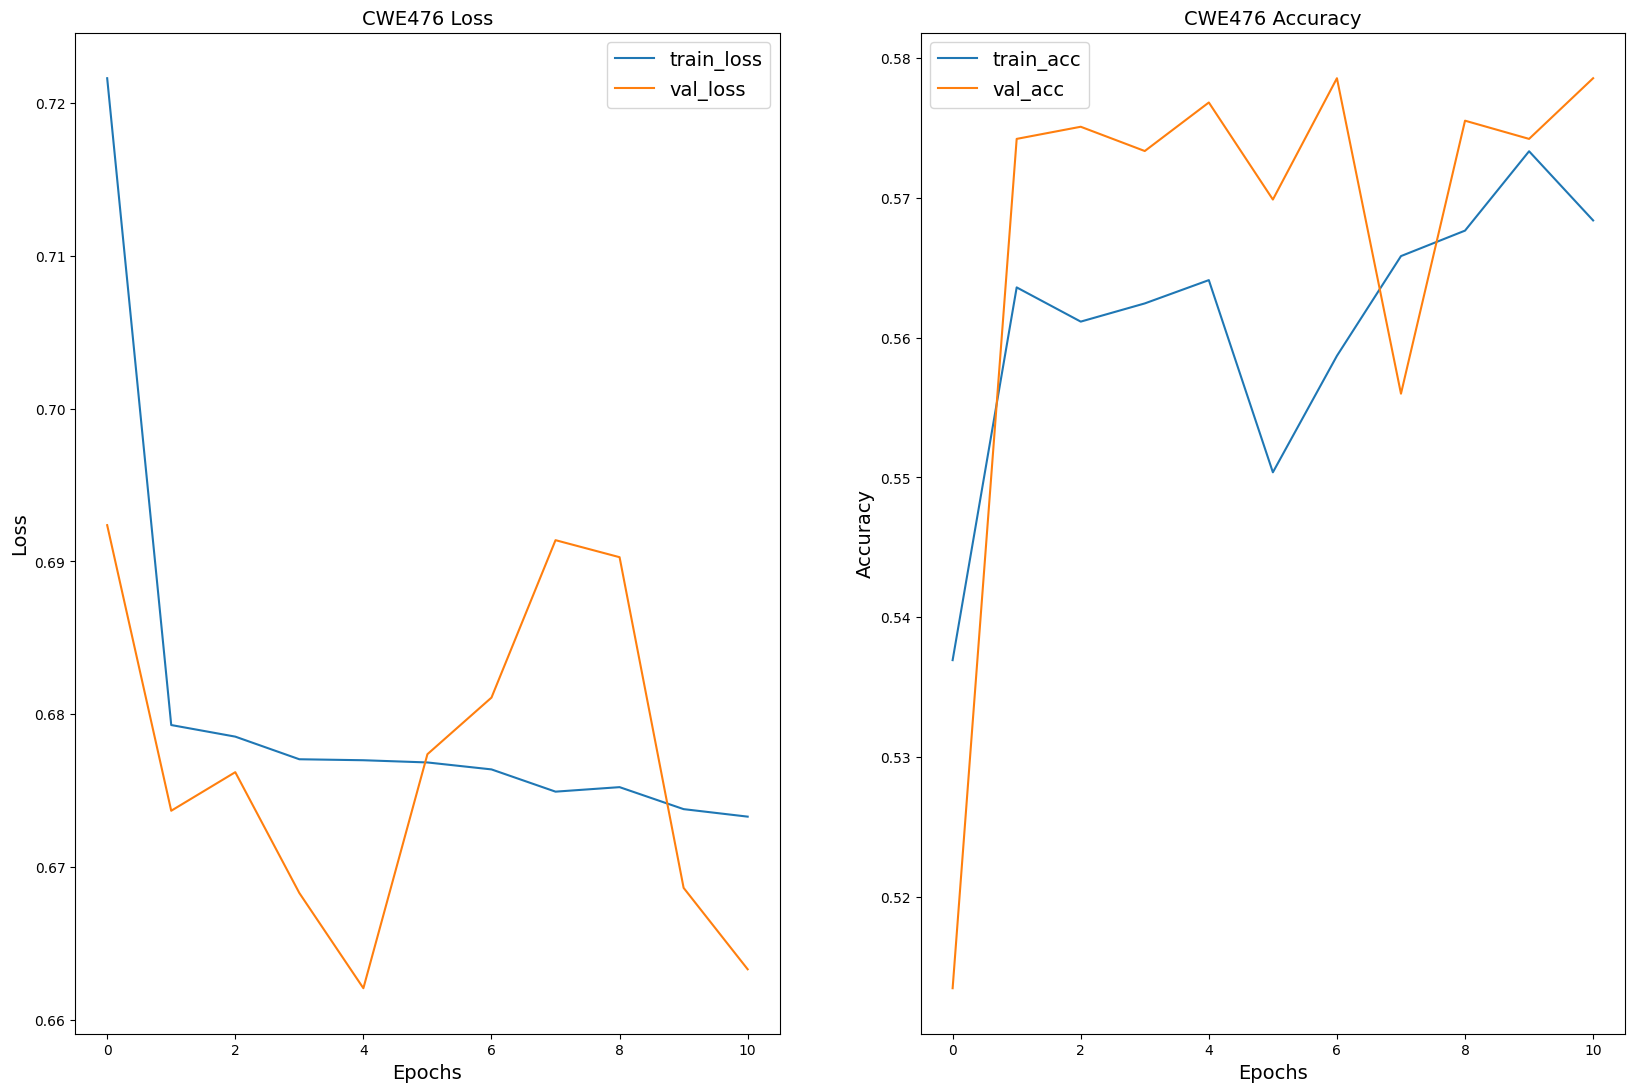

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.5779060181368508
Precision: 0.5659455687369156
Recall: 0.6685902720527618
F1 Score: 0.6130007558578987

Confusion Matrix:
[[591 622]
 [402 811]]


In [ ]:
val_losses_CWE476 = [x.item() for x in val_losses_CWE476] # Transfer values from gpu to cpu
plot_curves(train_losses_CWE476, val_losses_CWE476, train_acc_list_CWE476, val_acc_list_CWE476, "CWE476")
test_loader_all_476 = DataLoader(test_graphCWE476, batch_size=len(test_graphCWE476), drop_last=True, shuffle=True)
print_metrics(test_loader_all_476, model_CWE476)

- CWE OTHERS

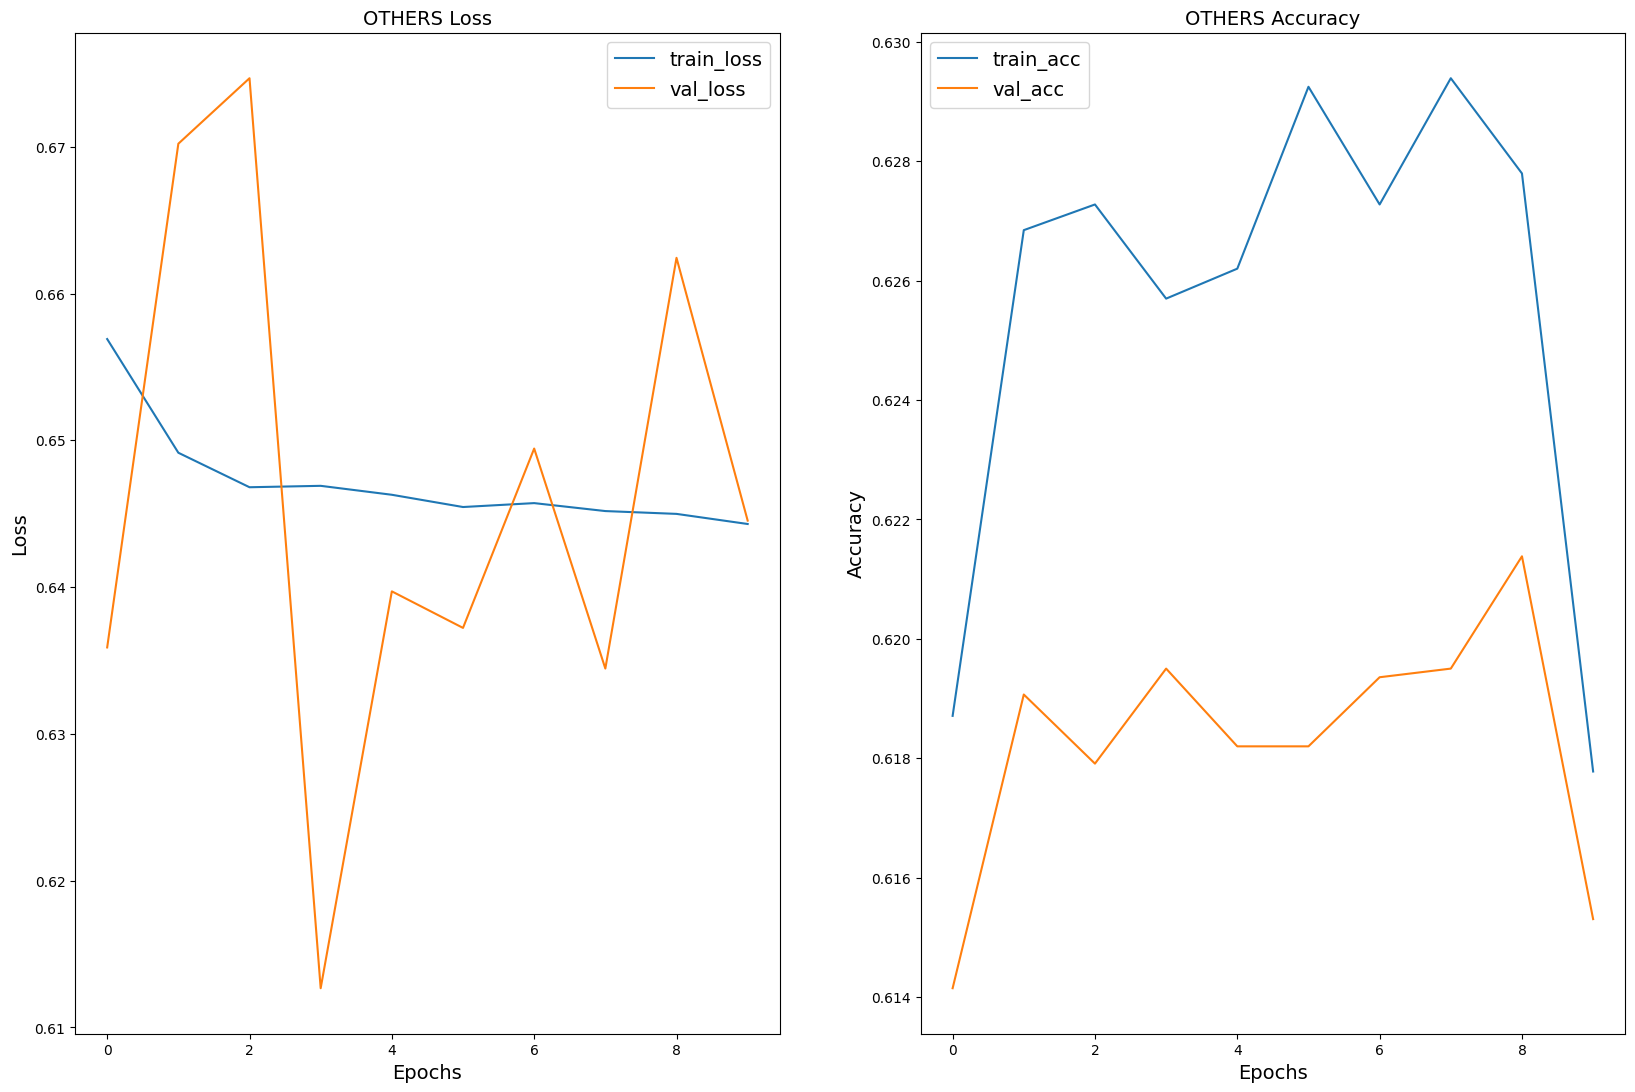

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 0.617315646840679
Precision: 0.5903352198519809
Recall: 0.7719897523484202
F1 Score: 0.6690514370297274

Confusion Matrix:
[[1616 1882]
 [ 801 2712]]


In [ ]:
val_losses_CWEOTHERS = [x.item() for x in val_losses_CWEOTHERS] # Transfer values from gpu to cpu
plot_curves(train_losses_CWEOTHERS, val_losses_CWEOTHERS, train_acc_list_CWEOTHERS, val_acc_list_CWEOTHERS, "OTHERS")
test_loader_all_OTHERS = DataLoader(test_graphCWEOTHERS, batch_size=len(test_graphCWEOTHERS), drop_last=True, shuffle=True)
print_metrics(test_loader_all_OTHERS, model_CWEOTHERS)

### Multilayer Perceptron

#### Labelling and Splitting dataset

Before we train we must add the correct labels of each sample in each dataset to the embedded datasets.

In [ ]:
# Preprocessed datasets for labels
preprocesed_CWE119 = pd.read_csv("./dataset/preprocessed/vdisc_CWE_119.csv.gz")
preprocesed_CWE120 = pd.read_csv("./dataset/preprocessed/vdisc_CWE_120.csv.gz")
preprocesed_CWE469 = pd.read_csv("./dataset/preprocessed/vdisc_CWE_469.csv.gz")
preprocesed_CWE476 = pd.read_csv("./dataset/preprocessed/vdisc_CWE_476.csv.gz")
preprocesed_CWEOTHERS = pd.read_csv("./dataset/preprocessed/vdisc_CWE_OTHERS.csv.gz")
# Embedded dataset
embedded_CWE119 = pd.read_csv("./dataset/embeddings/vector_CWE_119.csv")
embedded_CWE120 = pd.read_csv("./dataset/embeddings/vector_CWE_120.csv")
embedded_CWE469 = pd.read_csv("./dataset/embeddings/vector_CWE_469.csv")
embedded_CWE476 = pd.read_csv("./dataset/embeddings/vector_CWE_476.csv")
embedded_CWEOTHERS = pd.read_csv("./dataset/embeddings/vector_CWE_OTHERS.csv")


Convert the true and false values for the feature "vulnerable" to 1 and 0, respectively

In [ ]:
preprocesed_CWE119["vulnerable"] = preprocesed_CWE119["vulnerable"].astype(int)
preprocesed_CWE120["vulnerable"] = preprocesed_CWE120["vulnerable"].astype(int)
preprocesed_CWE469["vulnerable"] = preprocesed_CWE469["vulnerable"].astype(int)
preprocesed_CWE476["vulnerable"] = preprocesed_CWE476["vulnerable"].astype(int)
preprocesed_CWEOTHERS["vulnerable"] = preprocesed_CWEOTHERS["vulnerable"].astype(int)

In [ ]:
preprocesed_CWE119

,Unnamed: 0,testCase_ID,filename,code,vulnerable,type
0,0,0,0_vdisc.c,CDE_create_path_symlink_dirs() {\n char *p;\n...,1,CWE-119
1,1,1,1_vdisc.c,"gperror(unsigned int code,\n\t char *messa...",1,CWE-119
2,2,2,2_vdisc.c,test_date_rfc2822__format_rfc2822_positive_off...,1,CWE-119
3,3,3,3_vdisc.c,"toggle_cb (GtkWidget *item, char *pref_name)\n...",1,CWE-119
4,4,4,4_vdisc.c,"fixgrid34(NCDAPCOMMON* nccomm, CDFnode* grid)\...",1,CWE-119
...,...,...,...,...,...,...
48309,48309,48309,48309_vdisc.c,fuse_graph_sync (xlator_t *this)\n{\n f...,0,CWE-119
48310,48310,48310,48310_vdisc.c,"screen_resize(void)\n{\n gint w, h;\n GL...",0,CWE-119
48311,48311,48311,48311_vdisc.c,"cmd_cmpfiles (const char *assign_to, char *arg...",0,CWE-119
48312,48312,48312,48312_vdisc.c,etherType(PPPoEPacket *packet)\n{\n UINT16_...,0,CWE-119


Now we will get the labels from the preprocessed dataset and add them to the embedded one, this way we can use the dataset to train and validate classifiers.

In [ ]:
# Get classes for each dataset
y_CWE119 = preprocesed_CWE119.iloc[:,4]
y_CWE120 = preprocesed_CWE120.iloc[:,4]
y_CWE469 = preprocesed_CWE469.iloc[:,4]
y_CWE476 = preprocesed_CWE476.iloc[:,4]
y_CWEOTHERS = preprocesed_CWEOTHERS.iloc[:,4]
# Drop the column type (which is an index column basicly)
x_CWE119 = embedded_CWE119.drop(columns="type")
x_CWE120 = embedded_CWE120.drop(columns="type")
x_CWE469 = embedded_CWE469.drop(columns="type")
x_CWE476 = embedded_CWE476.drop(columns="type")
x_CWEOTHERS = embedded_CWEOTHERS.drop(columns="type")

Split the datasets into train (80%), test (10%) and validation (10%)

In [ ]:
# CWE-119
x_CWE119_train, x_CWE119_test, y_CWE119_train, y_CWE119_test = train_test_split(x_CWE119, y_CWE119, test_size=0.2, random_state=1)
x_CWE119_train, x_CWE119_validation, y_CWE119_train, y_CWE119_validation = train_test_split(x_CWE119_train, y_CWE119_train, test_size=0.25, random_state=1)
# CWE-120
x_CWE120_train, x_CWE120_test, y_CWE120_train, y_CWE120_test = train_test_split(x_CWE120, y_CWE120, test_size=0.2, random_state=1)
x_CWE120_train, x_CWE120_validation, y_CWE120_train, y_CWE120_validation = train_test_split(x_CWE120_train, y_CWE120_train, test_size=0.25, random_state=1)
# CWE-469
x_CWE469_train, x_CWE469_test, y_CWE469_train, y_CWE469_test = train_test_split(x_CWE469, y_CWE469, test_size=0.2, random_state=1)
x_CWE469_train, x_CWE469_validation, y_CWE469_train, y_CWE469_validation = train_test_split(x_CWE469_train, y_CWE469_train, test_size=0.25, random_state=1)
# CWE-476
x_CWE476_train, x_CWE476_test, y_CWE476_train, y_CWE476_test = train_test_split(x_CWE476, y_CWE476, test_size=0.2, random_state=1)
x_CWE476_train, x_CWE476_validation, y_CWE476_train, y_CWE476_validation = train_test_split(x_CWE476_train, y_CWE476_train, test_size=0.25, random_state=1)
# CWE-OTHERS
x_CWEOTHERS_train, x_CWEOTHERS_test, y_CWEOTHERS_train, y_CWEOTHERS_test = train_test_split(x_CWEOTHERS, y_CWEOTHERS, test_size=0.2, random_state=1)
x_CWEOTHERS_train, x_CWEOTHERS_validation, y_CWEOTHERS_train, y_CWEOTHERS_validation = train_test_split(x_CWEOTHERS_train, y_CWEOTHERS_train, test_size=0.25, random_state=1)

Now we create tensors, we will be using tensors because our MLP model will be created with PyTorch

In [ ]:
# CWE-119
x_CWE119_train_tensors = torch.FloatTensor(x_CWE119_train.values)
x_CWE119_test_tensors = torch.FloatTensor(x_CWE119_test.values)
x_CWE119_val_tensors = torch.FloatTensor(x_CWE119_validation.values)
y_CWE119_train_tensors = torch.tensor(y_CWE119_train.values)
y_CWE119_test_tensors = torch.tensor(y_CWE119_test.values)
y_CWE119_val_tensors = torch.tensor(y_CWE119_validation.values)

# CWE-120
x_CWE120_train_tensors = torch.FloatTensor(x_CWE120_train.values)
x_CWE120_test_tensors = torch.FloatTensor(x_CWE120_test.values)
x_CWE120_val_tensors = torch.FloatTensor(x_CWE120_validation.values)
y_CWE120_train_tensors = torch.tensor(y_CWE120_train.values)
y_CWE120_test_tensors = torch.tensor(y_CWE120_test.values)
y_CWE120_val_tensors = torch.tensor(y_CWE120_validation.values)

# CWE-469
x_CWE469_train_tensors = torch.FloatTensor(x_CWE469_train.values)
x_CWE469_test_tensors = torch.FloatTensor(x_CWE469_test.values)
x_CWE469_val_tensors = torch.FloatTensor(x_CWE469_validation.values)
y_CWE469_train_tensors = torch.tensor(y_CWE469_train.values)
y_CWE469_test_tensors = torch.tensor(y_CWE469_test.values)
y_CWE469_val_tensors = torch.tensor(y_CWE469_validation.values)

# CWE-476
x_CWE476_train_tensors = torch.FloatTensor(x_CWE476_train.values)
x_CWE476_test_tensors = torch.FloatTensor(x_CWE476_test.values)
x_CWE476_val_tensors = torch.FloatTensor(x_CWE476_validation.values)
y_CWE476_train_tensors = torch.tensor(y_CWE476_train.values)
y_CWE476_test_tensors = torch.tensor(y_CWE476_test.values)
y_CWE476_val_tensors = torch.tensor(y_CWE476_validation.values)

# CWE-OTHERS
x_CWEOTHERS_train_tensors = torch.FloatTensor(x_CWEOTHERS_train.values)
x_CWEOTHERS_test_tensors = torch.FloatTensor(x_CWEOTHERS_test.values)
x_CWEOTHERS_val_tensors = torch.FloatTensor(x_CWEOTHERS_validation.values)
y_CWEOTHERS_train_tensors = torch.tensor(y_CWEOTHERS_train.values)
y_CWEOTHERS_test_tensors = torch.tensor(y_CWEOTHERS_test.values)
y_CWEOTHERS_val_tensors = torch.tensor(y_CWEOTHERS_validation.values)


#### Creating the model

Now we will create the MLP model in PyTorch. We will be following the same architecture the author of the article used.

NN Architecture:  
- Input Layer: 128 Neurons with a ReLU activation function
- Hidden Layer: 128 Neurons with a ReLU activation function
- Output Lyaer: 1 Neuron with a Sigmoid activation function

In [ ]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

To train this model we will first have to define some functions.  

Here we define functions to evaluate and train one epoch, which will be intregrated into the train_model function which will be in charge of training the model for the specified number of epochs or until it there is no improvement in the validation loss after the early_stopping_patience period defined.  

And finally a train cwe function to avoid repeating the same code for each dataset.

In [ ]:
def evaluate(x_tensors, y_tensors, model, criterion):
    model.eval()
    y_pred = model(x_tensors)
    loss  = criterion(y_pred.squeeze(), y_tensors.float()) 
    return accuracy_score(y_tensors.detach().cpu().numpy(), np.rint(y_pred.cpu().detach().numpy())), loss

def train(x_train_tensors, y_train_tensors, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_tensors)    
    loss = criterion(y_pred.squeeze(), y_train_tensors.float())
    loss.backward()
    optimizer.step()
    return loss

def train_model(epochs, early_stopping_patience, train_function, evaluate_function, x_train_tensors, y_train_tensors, x_val_tensors, y_val_tensors, model, criterion, optimizer):
    print("Starting training...")
    train_losses = []
    val_losses = []
    val_acc_list = []
    train_acc_list = []
    best_loss = 1000
    early_stopping_counter = 0

    for epoch in range(epochs):
        if early_stopping_counter <= early_stopping_patience:
            loss = train_function(x_train_tensors, y_train_tensors, model, criterion, optimizer)
            train_losses.append(loss)
            train_acc, train_loss = evaluate_function(x_train_tensors, y_train_tensors, model, criterion)
            val_acc, val_loss = evaluate_function(x_val_tensors, y_val_tensors, model, criterion)
            val_losses.append(val_loss)
            val_acc_list.append(val_acc)
            train_acc_list.append(train_acc)

            if float(val_loss) < best_loss:
                best_loss = val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            print(f"Epoch {epoch} | Train Loss {loss} | Train Accuracy {train_acc} | Validation Accuracy {val_acc} | Validation loss {best_loss}")

        else:
            print("Early stopping due to no improvement.")
            break

    print(f"Finishing training with best validation loss: {best_loss}")
    return train_losses, val_losses, train_acc_list, val_acc_list

def train_cwe_model(cwe_name, x_train_tensors, y_train_tensors, x_test_tensors, y_test_tensors, x_val_tensors, y_val_tensors):
    print(f"Training model for {cwe_name}...")
    model = MLP()
    device = torch.device("cpu")
    model.to(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.eval()
    y_pred = model(x_test_tensors)
    loss_before_train = criterion(y_pred.squeeze(), y_test_tensors.float())
    print(f'Test loss before training for {cwe_name}:', loss_before_train.item())
    
    train_losses, val_losses, train_acc_list, val_acc_list = train_model(epochs=200, 
                                                                         early_stopping_patience=5, 
                                                                         train_function=train, 
                                                                         evaluate_function=evaluate, 
                                                                         x_train_tensors=x_train_tensors,
                                                                         y_train_tensors=y_train_tensors,
                                                                         x_val_tensors=x_val_tensors, 
                                                                         y_val_tensors=y_val_tensors,
                                                                         model=model, 
                                                                         criterion=criterion,
                                                                         optimizer=optimizer)
    return model, train_losses, val_losses, train_acc_list, val_acc_list

#### Training

Now we will create a model for each of the datasets and train it.

- CWE-119

In [ ]:
model_119, train_losses_119, val_losses_119, train_acc_list_119, val_acc_list_119 = train_cwe_model("CWE-119", 
                                                                                                    x_CWE119_train_tensors, 
                                                                                                    y_CWE119_train_tensors, 
                                                                                                    x_CWE119_test_tensors, 
                                                                                                    y_CWE119_test_tensors, 
                                                                                                    x_CWE119_val_tensors, 
                                                                                                    y_CWE119_val_tensors)

Training model for CWE-119...
Test loss before training for CWE-119: 0.6931899189949036
Starting training...
Epoch 0 | Train Loss 0.6930686831474304 | Train Accuracy 0.49813716020422244 | Validation Accuracy 0.5012935941219083 | Validation loss 0.6956760287284851
Epoch 1 | Train Loss 0.6965469717979431 | Train Accuracy 0.5541948392438251 | Validation Accuracy 0.5539687467660147 | Validation loss 0.6901207566261292
Epoch 2 | Train Loss 0.6897929310798645 | Train Accuracy 0.526114254174141 | Validation Accuracy 0.5155748732277761 | Validation loss 0.6901207566261292
Epoch 3 | Train Loss 0.690284788608551 | Train Accuracy 0.5509176210845868 | Validation Accuracy 0.5473455448618442 | Validation loss 0.687872052192688
Epoch 4 | Train Loss 0.6870605945587158 | Train Accuracy 0.5678901614461156 | Validation Accuracy 0.5655593500983132 | Validation loss 0.6844466328620911
Epoch 5 | Train Loss 0.6838197112083435 | Train Accuracy 0.5648544225196633 | Validation Accuracy 0.5679395632826244 | Vali

- CWE-120

In [ ]:
model_120, train_losses_120, val_losses_120, train_acc_list_120, val_acc_list_120 = train_cwe_model("CWE-120", 
                                                                                                    x_CWE120_train_tensors, 
                                                                                                    y_CWE120_train_tensors, 
                                                                                                    x_CWE120_test_tensors, 
                                                                                                    y_CWE120_test_tensors,
                                                                                                    x_CWE120_val_tensors,
                                                                                                    y_CWE120_val_tensors)

Training model for CWE-120...
Test loss before training for CWE-120: 0.6943444609642029
Starting training...
Epoch 0 | Train Loss 0.694110095500946 | Train Accuracy 0.49972024059308995 | Validation Accuracy 0.49790180444817456 | Validation loss 0.689886748790741
Epoch 1 | Train Loss 0.689073383808136 | Train Accuracy 0.6223422856343545 | Validation Accuracy 0.6176038606798153 | Validation loss 0.681357741355896
Epoch 2 | Train Loss 0.680683434009552 | Train Accuracy 0.6195097216393901 | Validation Accuracy 0.6146139320184641 | Validation loss 0.6717250347137451
Epoch 3 | Train Loss 0.6703042387962341 | Train Accuracy 0.613774653797734 | Validation Accuracy 0.6104175409148133 | Validation loss 0.6710357666015625
Epoch 4 | Train Loss 0.6680446863174438 | Train Accuracy 0.6078822212896908 | Validation Accuracy 0.6066932438103231 | Validation loss 0.6645601987838745
Epoch 5 | Train Loss 0.6629058122634888 | Train Accuracy 0.6062561197370262 | Validation Accuracy 0.604699958036089 | Validat

CWE-469

In [ ]:
model_469, train_losses_469, val_losses_469, train_acc_list_469, val_acc_list_469 = train_cwe_model("CWE-469", 
                                                                                                    x_CWE469_train_tensors, 
                                                                                                    y_CWE469_train_tensors, 
                                                                                                    x_CWE469_test_tensors, 
                                                                                                    y_CWE469_test_tensors, 
                                                                                                    x_CWE469_val_tensors, 
                                                                                                    y_CWE469_val_tensors)

Training model for CWE-469...
Test loss before training for CWE-469: 0.6967766284942627
Starting training...
Epoch 0 | Train Loss 0.69562166929245 | Train Accuracy 0.49936507936507935 | Validation Accuracy 0.4942857142857143 | Validation loss 0.6932717561721802
Epoch 1 | Train Loss 0.6922059655189514 | Train Accuracy 0.4996825396825397 | Validation Accuracy 0.4942857142857143 | Validation loss 0.6912721991539001
Epoch 2 | Train Loss 0.6903373003005981 | Train Accuracy 0.5241269841269841 | Validation Accuracy 0.5047619047619047 | Validation loss 0.6893491148948669
Epoch 3 | Train Loss 0.6879567503929138 | Train Accuracy 0.5349206349206349 | Validation Accuracy 0.49714285714285716 | Validation loss 0.6876786947250366
Epoch 4 | Train Loss 0.6852965950965881 | Train Accuracy 0.5714285714285714 | Validation Accuracy 0.5533333333333333 | Validation loss 0.6846915483474731
Epoch 5 | Train Loss 0.6823124289512634 | Train Accuracy 0.5768253968253968 | Validation Accuracy 0.579047619047619 | Val

CWE-476

In [ ]:
model_476, train_losses_476, val_losses_476, train_acc_list_476, val_acc_list_476 = train_cwe_model("CWE-476", 
                                                                                                    x_CWE476_train_tensors, 
                                                                                                    y_CWE476_train_tensors, 
                                                                                                    x_CWE476_test_tensors, 
                                                                                                    y_CWE476_test_tensors, 
                                                                                                    x_CWE476_val_tensors, 
                                                                                                    y_CWE476_val_tensors)

Training model for CWE-476...
Test loss before training for CWE-476: 0.6932016015052795
Starting training...
Epoch 0 | Train Loss 0.693086564540863 | Train Accuracy 0.5043412348401323 | Validation Accuracy 0.5109549400578751 | Validation loss 0.6922227144241333
Epoch 1 | Train Loss 0.6922165751457214 | Train Accuracy 0.499242006615215 | Validation Accuracy 0.4923522116577098 | Validation loss 0.6922227144241333
Epoch 2 | Train Loss 0.6987273693084717 | Train Accuracy 0.5215683572216097 | Validation Accuracy 0.5105415460934271 | Validation loss 0.6922227144241333
Epoch 3 | Train Loss 0.6916859149932861 | Train Accuracy 0.5046857772877619 | Validation Accuracy 0.510334849111203 | Validation loss 0.6922227144241333
Epoch 4 | Train Loss 0.6928737759590149 | Train Accuracy 0.5056504961411246 | Validation Accuracy 0.5088879702356346 | Validation loss 0.6922227144241333
Epoch 5 | Train Loss 0.6917611360549927 | Train Accuracy 0.5227398015435502 | Validation Accuracy 0.5115750310045474 | Valid

CWE-OTHERS

In [ ]:
model_OTHERS, train_losses_OTHERS, val_losses_OTHERS, train_acc_list_OTHERS, val_acc_list_OTHERS = train_cwe_model("CWE-OTHERS", 
                                                                                                                   x_CWEOTHERS_train_tensors, 
                                                                                                                   y_CWEOTHERS_train_tensors, 
                                                                                                                   x_CWEOTHERS_test_tensors, 
                                                                                                                   y_CWEOTHERS_test_tensors,
                                                                                                                   x_CWEOTHERS_val_tensors,
                                                                                                                   y_CWEOTHERS_val_tensors)

Training model for CWE-OTHERS...
Test loss before training for CWE-OTHERS: 0.6948480010032654
Starting training...
Epoch 0 | Train Loss 0.6940982937812805 | Train Accuracy 0.4983703280755597 | Validation Accuracy 0.4946827492684319 | Validation loss 0.6949576139450073
Epoch 1 | Train Loss 0.6941550970077515 | Train Accuracy 0.5288463826041444 | Validation Accuracy 0.5250160588109343 | Validation loss 0.6900919079780579
Epoch 2 | Train Loss 0.6899034976959229 | Train Accuracy 0.5683867437489591 | Validation Accuracy 0.5659838698165727 | Validation loss 0.687616765499115
Epoch 3 | Train Loss 0.6875578761100769 | Train Accuracy 0.5649846549139962 | Validation Accuracy 0.5627007351366783 | Validation loss 0.6842179894447327
Epoch 4 | Train Loss 0.6840883493423462 | Train Accuracy 0.5658173339994766 | Validation Accuracy 0.5639140675183785 | Validation loss 0.6835353374481201
Epoch 5 | Train Loss 0.6836035251617432 | Train Accuracy 0.5654842623652844 | Validation Accuracy 0.5683391620869317

#### Evaluation

In [ ]:
def plot_cwe_results(cwe_name, train_losses, val_losses, train_acc_list, val_acc_list):
    with torch.no_grad():
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 13))
        
        ax1.plot(train_losses, label="train_loss")
        ax1.plot(val_losses, label="val_loss")
        ax1.set_ylabel('Loss', fontsize=14)
        ax1.set_xlabel('Epochs', fontsize=14)
        lines, labels = ax1.get_legend_handles_labels()
        ax1.legend(lines, labels, loc='best', fontsize=14)

        ax2.plot(train_acc_list, label='train_acc')
        ax2.plot(val_acc_list, label='val_acc')
        ax2.legend(fontsize=14)
        ax2.set_ylabel('Accuracy', fontsize=14)
        ax2.set_xlabel('Epochs', fontsize=14)
        
        plt.suptitle(f"{cwe_name} Losses and Accuracy", fontsize=16)
        plt.savefig(f'{cwe_name}_losses_accuracy.png')
        plt.show()


def compute_performance_metrics(cwe_name, model, x_test_tensors, y_test_tensors):
    with torch.no_grad():
        y_pred = model(x_test_tensors)
        df = pd.DataFrame()
        df["y_pred"] = y_pred.tolist()

    df["y_real"] = y_test_tensors.tolist()
    y_pred = np.rint(y_pred)
    accuracy = accuracy_score(y_test_tensors, y_pred)
    precision = precision_score(y_test_tensors, y_pred, zero_division=1)
    recall = recall_score(y_test_tensors, y_pred, zero_division=1)
    F1 = f1_score(y_test_tensors, y_pred, zero_division=1)
    mcc = matthews_corrcoef(y_test_tensors, y_pred)

    print(f"{cwe_name} Performance Metrics:")
    print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(accuracy, precision, recall, F1))
    print(" MCC : {0}".format(mcc))
    print()

- CWE-119

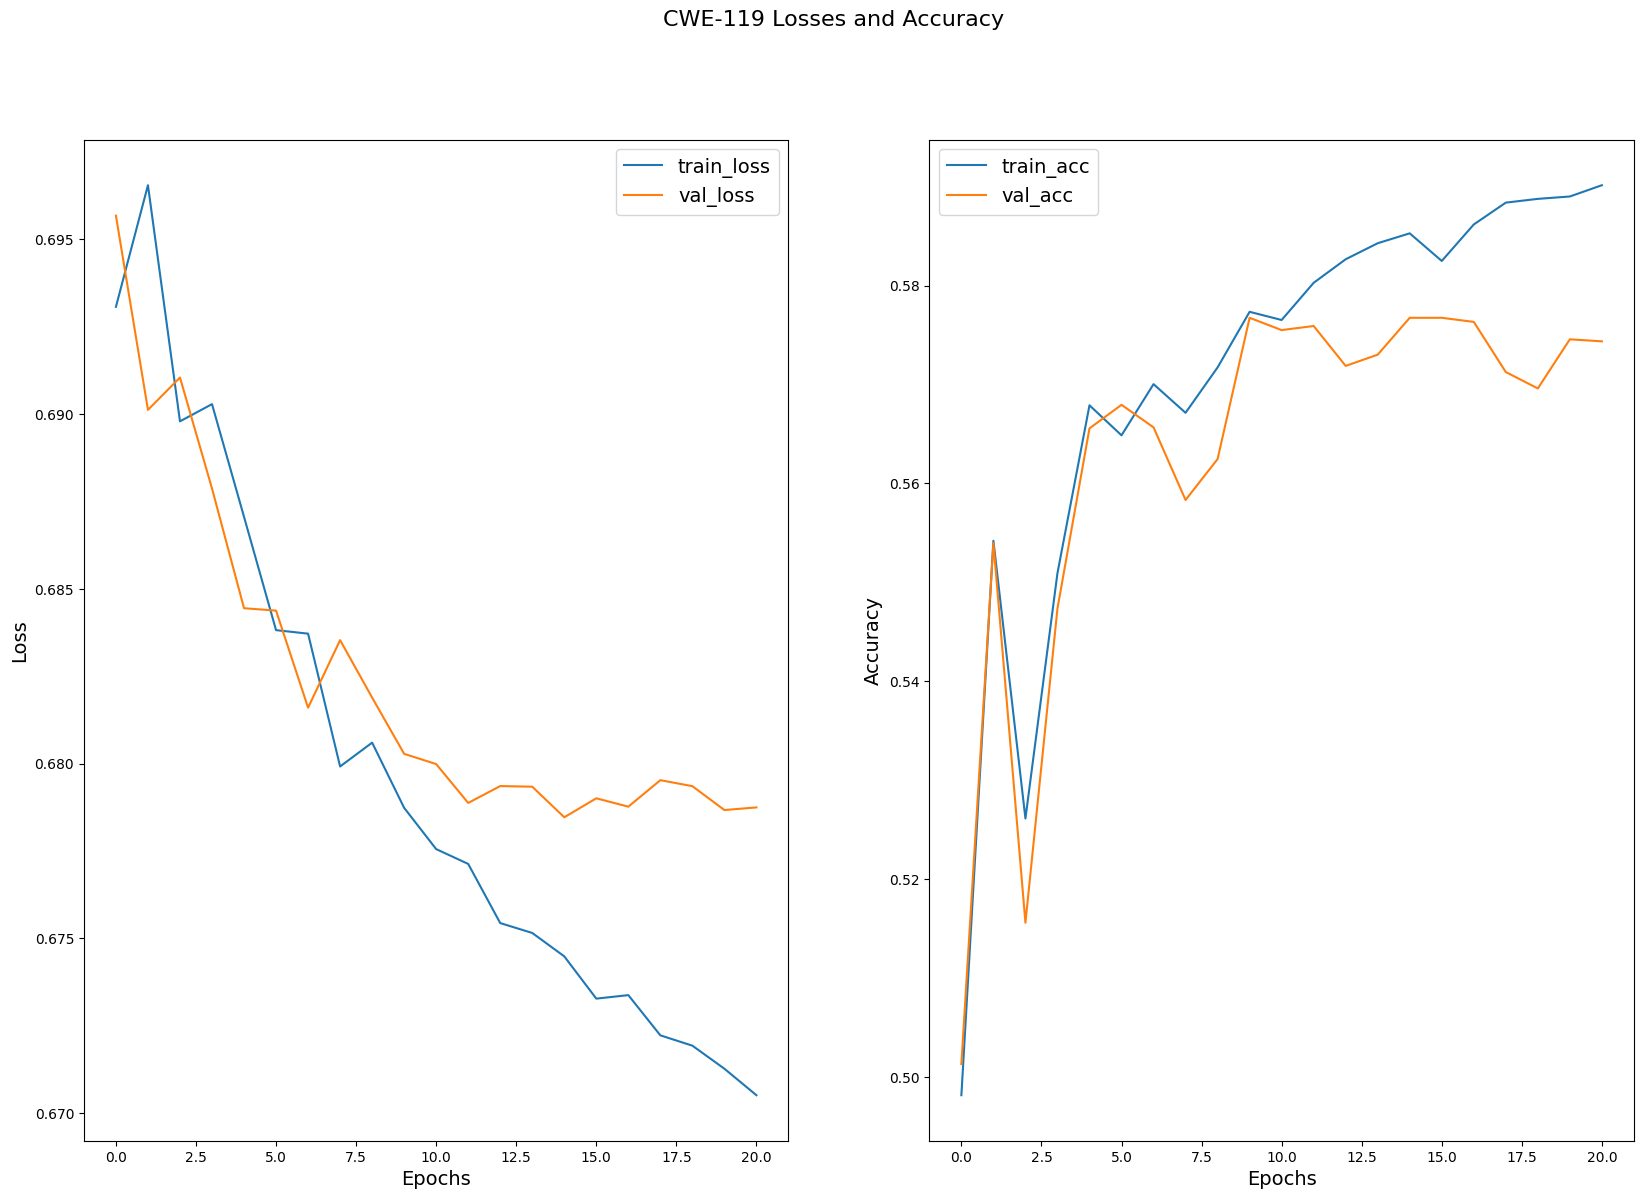

In [ ]:
plot_cwe_results("CWE-119", train_losses_119, val_losses_119, train_acc_list_119, val_acc_list_119)

In [ ]:
compute_performance_metrics("CWE-119", model_119, x_CWE119_test_tensors, y_CWE119_test_tensors)

CWE-119 Performance Metrics:
 Accuracy : 0.5800476042636862 
 Precision : 0.5745108795026513 
 Recall : 0.644777344551611 
 F1 : 0.6076194159736995
 MCC : 0.16036986382660662



- CWE-120

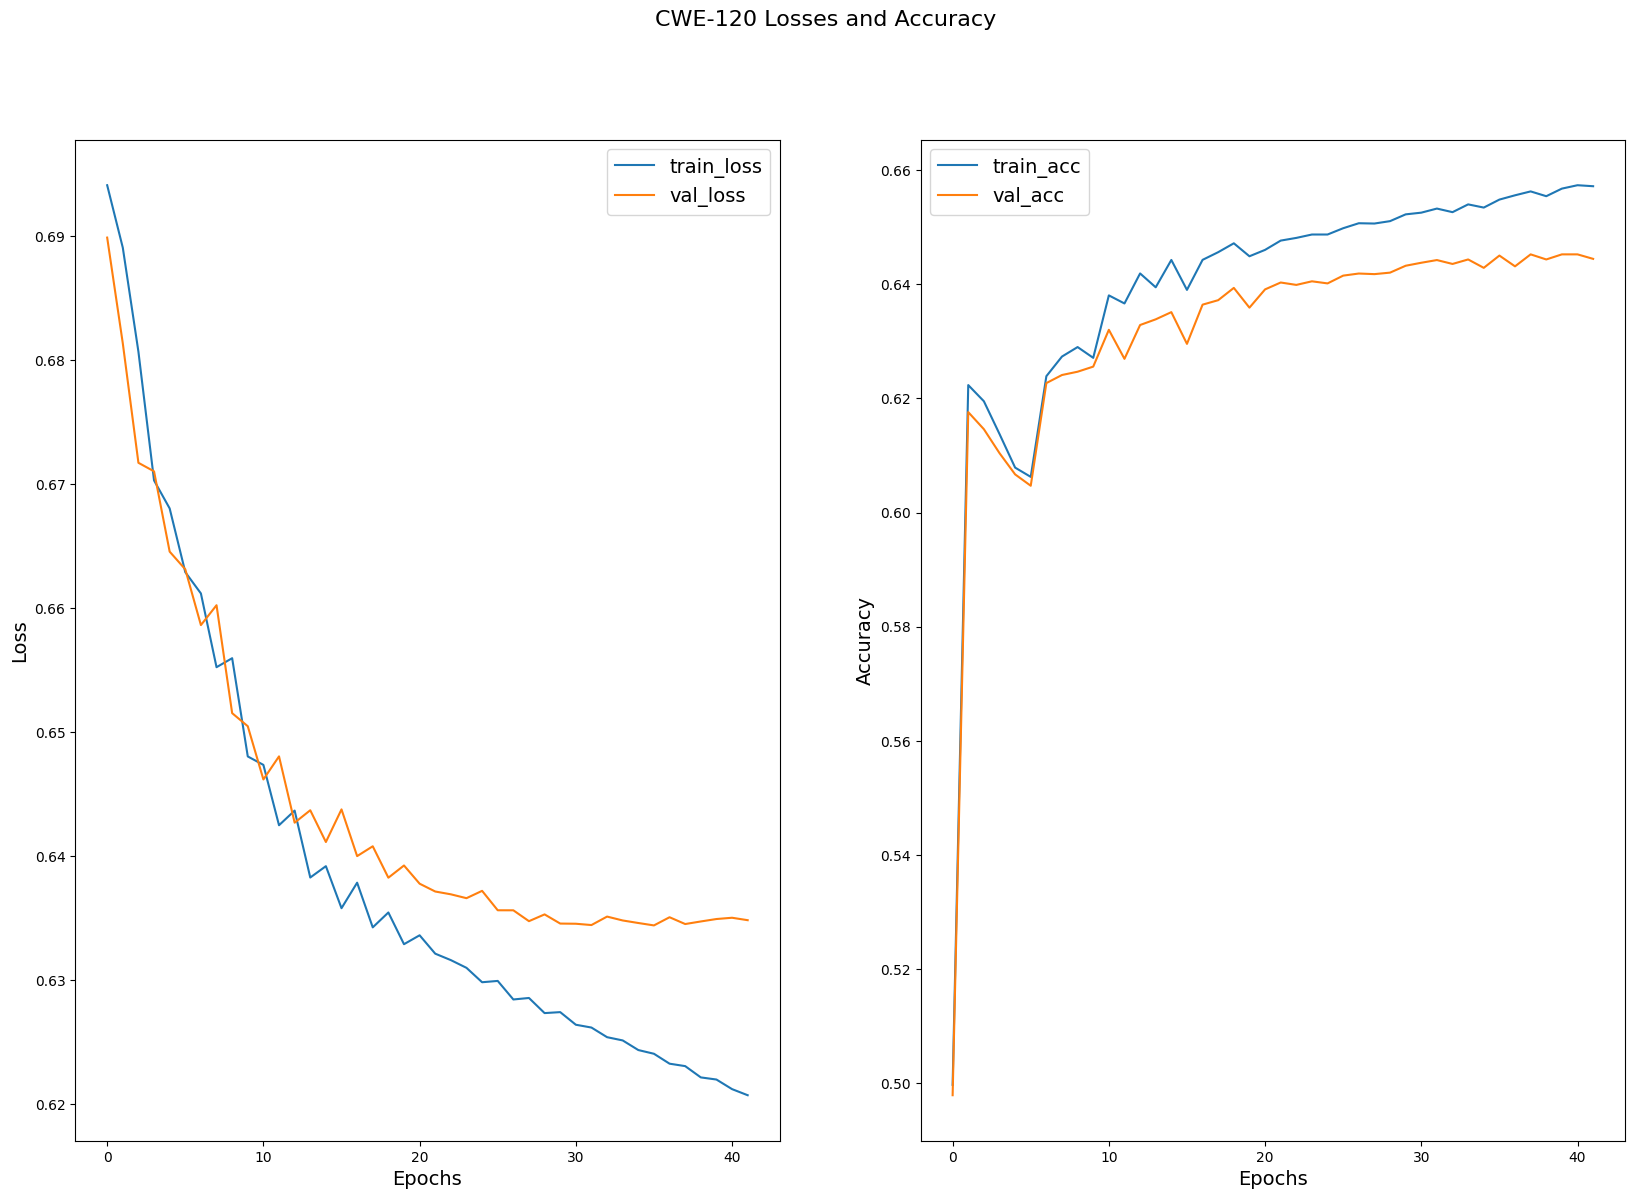

In [ ]:
plot_cwe_results("CWE-120", train_losses_120, val_losses_120, train_acc_list_120, val_acc_list_120)

In [ ]:
compute_performance_metrics("CWE-120", model_120, x_CWE120_test_tensors, y_CWE120_test_tensors)

CWE-120 Performance Metrics:
 Accuracy : 0.6501783466219052 
 Precision : 0.6576985413290114 
 Recall : 0.6348560700876095 
 F1 : 0.6460754656901767
 MCC : 0.30065958368678136



- CWE-469

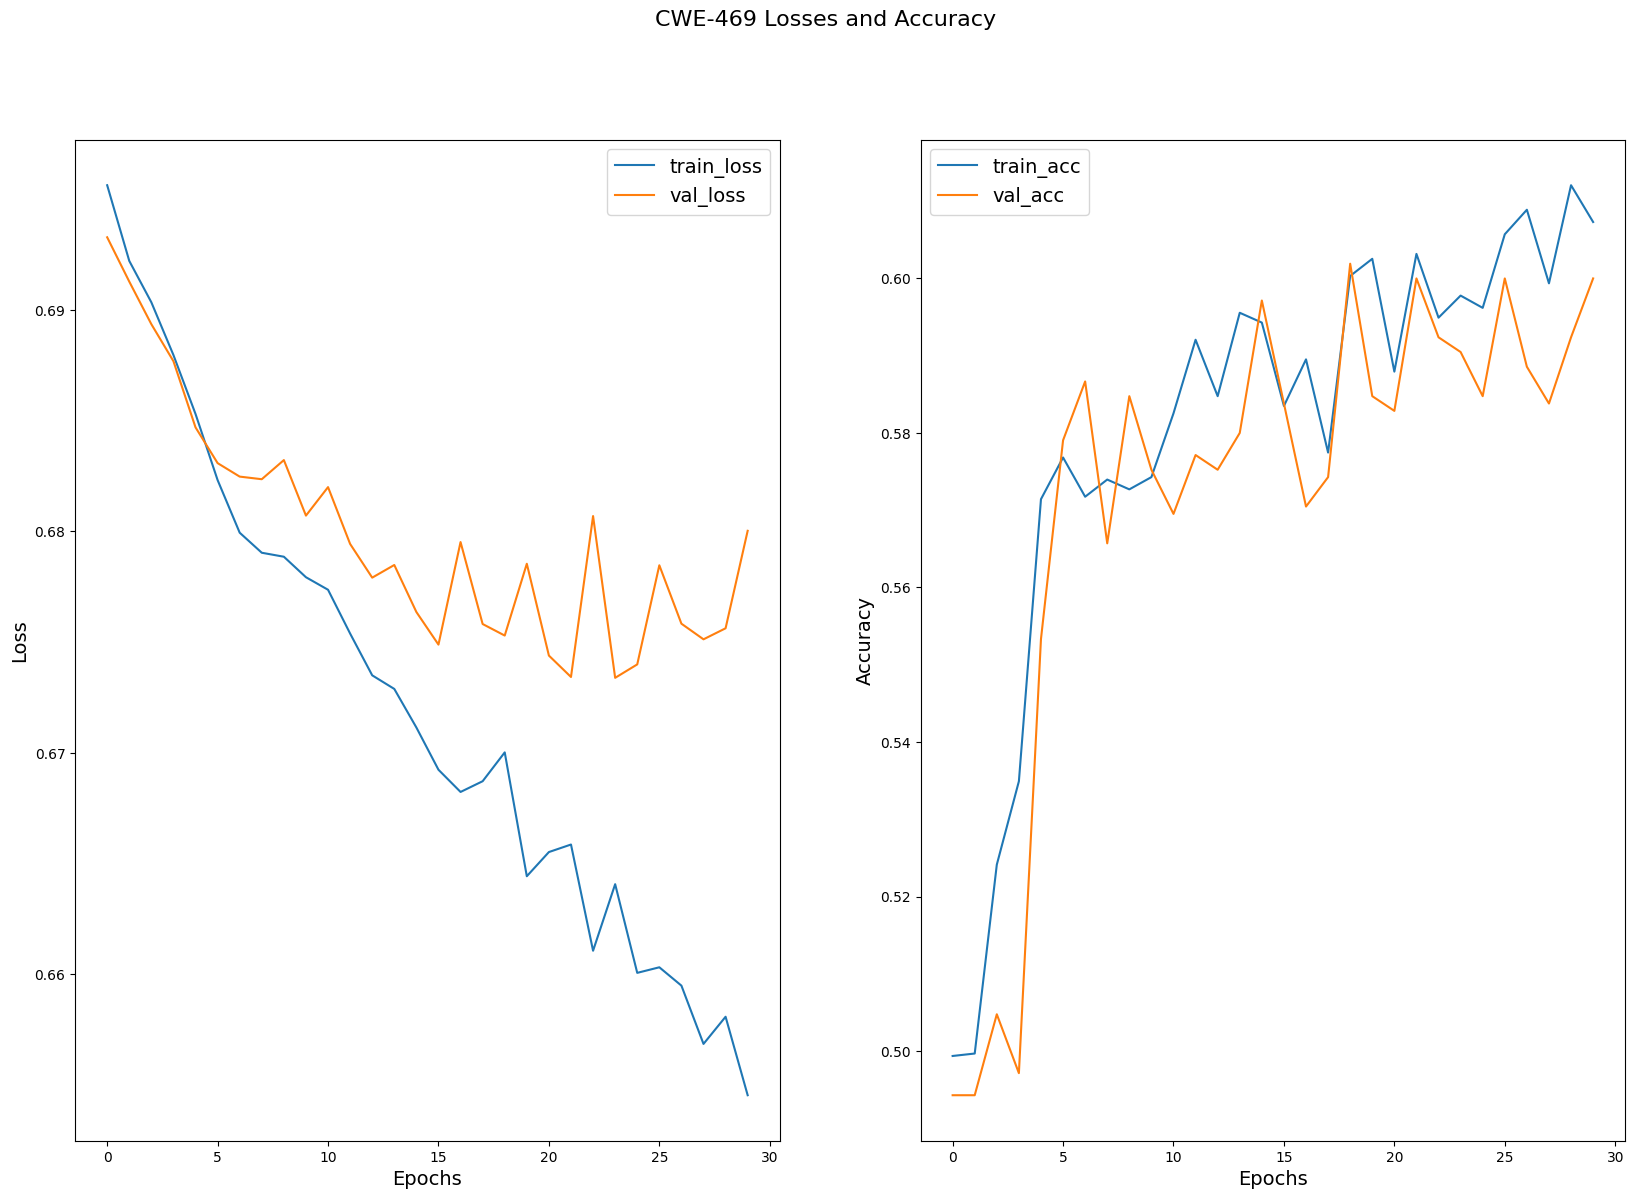

In [ ]:
plot_cwe_results("CWE-469", train_losses_469, val_losses_469, train_acc_list_469, val_acc_list_469)

In [ ]:
compute_performance_metrics("CWE-469", model_469, x_CWE469_test_tensors, y_CWE469_test_tensors)

CWE-469 Performance Metrics:
 Accuracy : 0.5866666666666667 
 Precision : 0.5854922279792746 
 Recall : 0.6360225140712945 
 F1 : 0.6097122302158273
 MCC : 0.17270191890003161



- CWE-476

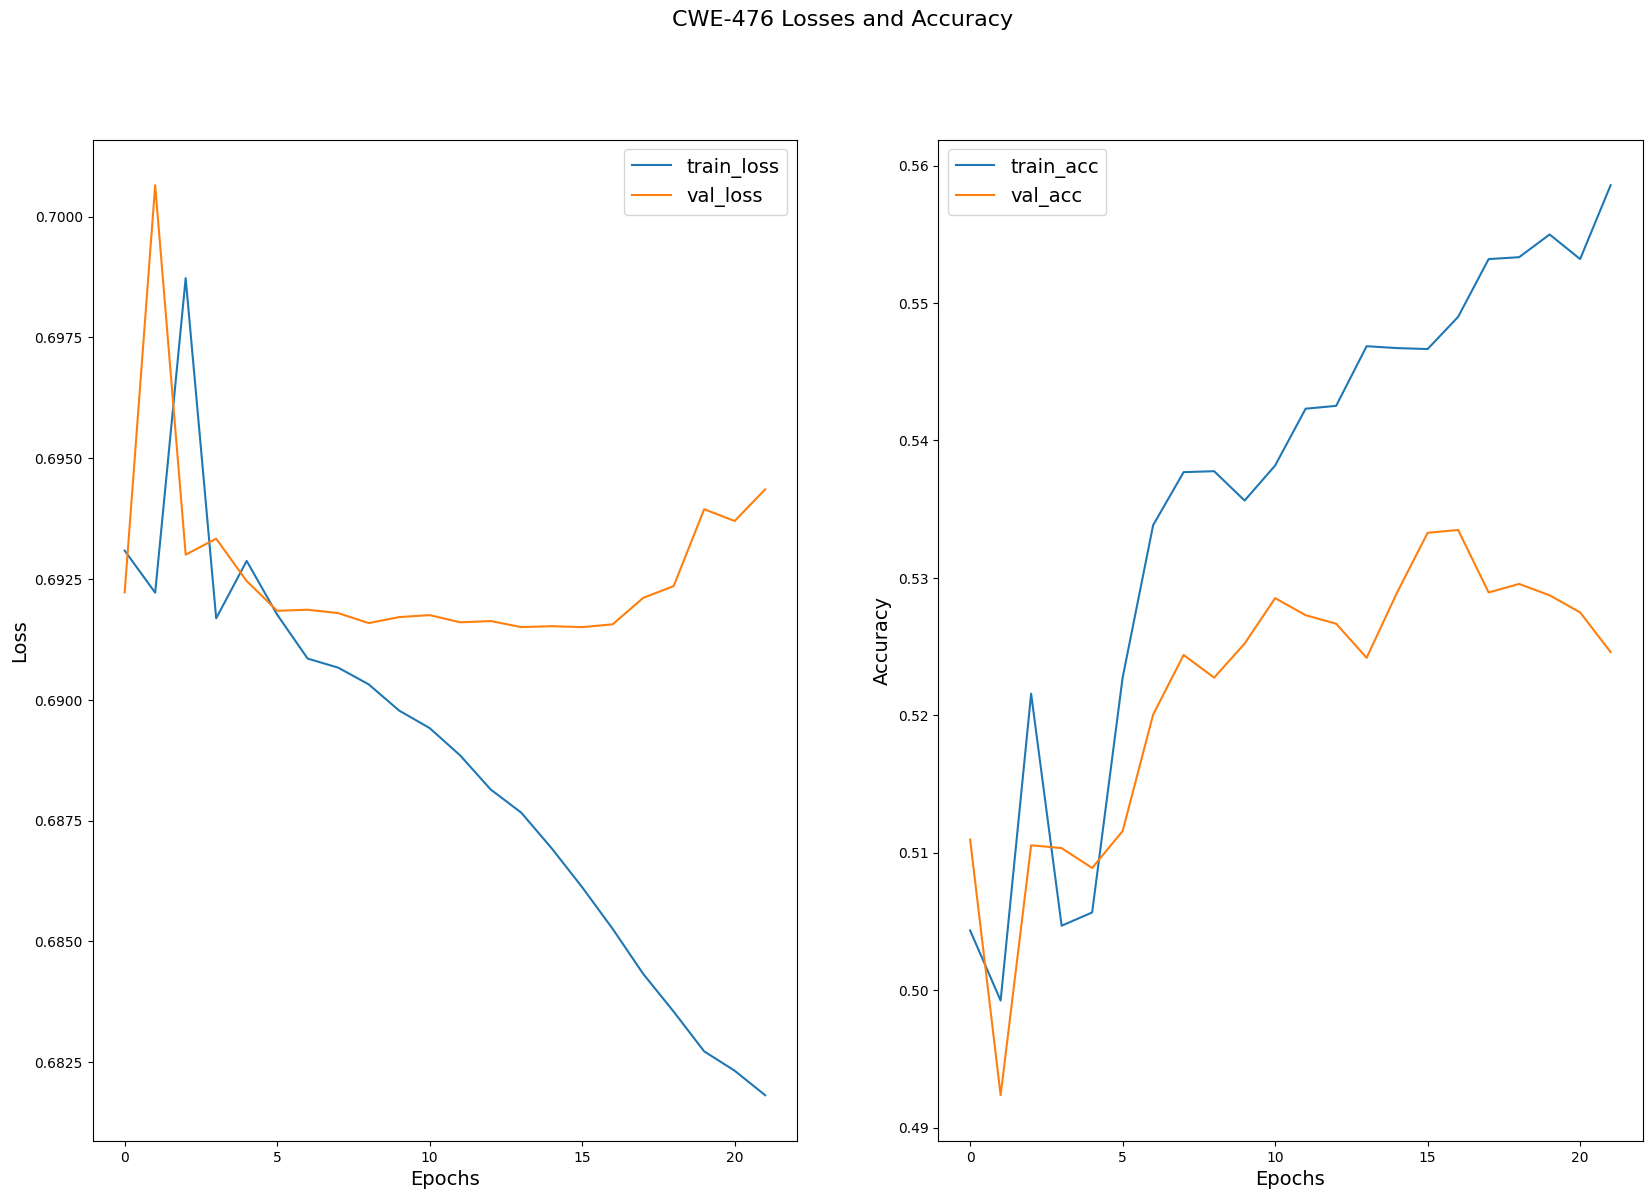

In [ ]:
plot_cwe_results("CWE-476", train_losses_476, val_losses_476, train_acc_list_476, val_acc_list_476)

In [ ]:
compute_performance_metrics("CWE-476", model_476, x_CWE476_test_tensors, y_CWE476_test_tensors)

CWE-476 Performance Metrics:
 Accuracy : 0.5239768499379909 
 Precision : 0.5322812051649928 
 Recall : 0.5976641159887233 
 F1 : 0.5630810092961487
 MCC : 0.04445347475748857



- CWE OTHERS

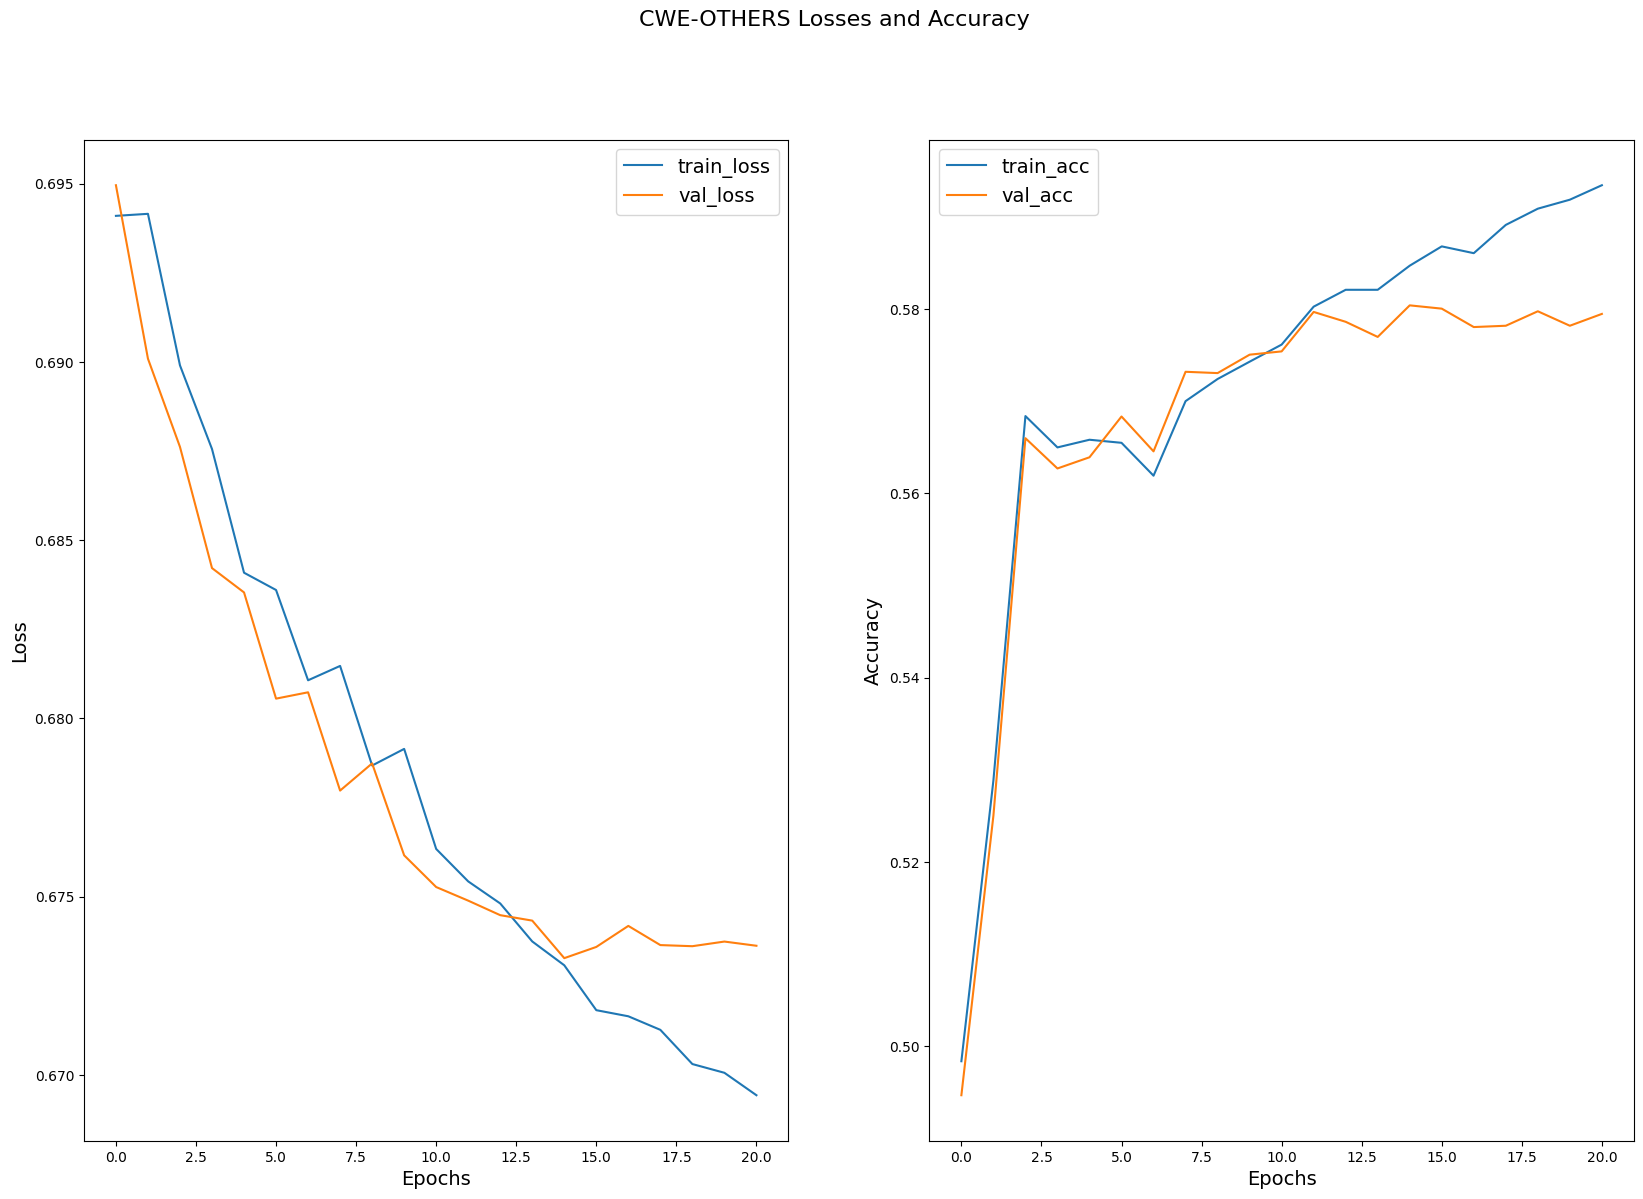

In [ ]:
plot_cwe_results("CWE-OTHERS", train_losses_OTHERS, val_losses_OTHERS, train_acc_list_OTHERS, val_acc_list_OTHERS)

In [ ]:
compute_performance_metrics("CWE-OTHERS", model_OTHERS, x_CWEOTHERS_test_tensors, y_CWEOTHERS_test_tensors)

CWE-OTHERS Performance Metrics:
 Accuracy : 0.5871395946331716 
 Precision : 0.5962732919254659 
 Recall : 0.5908518673940412 
 F1 : 0.5935502002388816
 MCC : 0.17409900391954333

